## Can we fit the remaining variance?
### Using W-S as the input for the RP transform


In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
import lasio
import pandas as pd
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from subprocess import call
import seaborn as sns
import matplotlib.cm as cm
sns.set(color_codes=True)
from funcs import *

In [2]:
workdir = Path('../')
lasdir = workdir.joinpath('data','las_MPWSP')
auxdir=  workdir.joinpath('data','auxiliary')
figdir=  workdir.joinpath('work','figs')

### Create common masks and functions

In [3]:
# def mask_nonan(df,nan_col_list):
#     mask = df.notnull()
#     return mask.loc[:,nan_col_list].all(axis=1)

# def mask_noclay(df,nan_col_list):
#     return ~df.loc[mask_nonan(df,nan_col_list),'lith'].str.contains("C")

# def mask_SP_only(df,nan_col_list):
#     return df.loc[mask_nonan(df,nan_col_list),'lith']=="SP"

# def mask_stds(df,nstds,testcol,nan_col_list):
#     pop = df.loc[mask_nonan(df,nan_col_list),testcol]
#     return  np.logical_and(pop < np.mean(pop)+nstds*np.std(pop),
#                            pop > np.mean(pop)-nstds*np.std(pop))
# def mask_wherescreen(df,nan_col_list):
#     return  mask_nonan(df[df.screen.notnull()],nan_cols)
def export_tree(export_dir,reg,max_depth,predictors,prefix='BagTree_',**kwargs):
    #Export graphs
    from sklearn import tree
    fig_suffix = '{numlevels}lvls_{predictors}.png'.format(numlevels=max_depth,predictors='-'.join(predictors))
    tree.export_graphviz(reg,out_file=export_dir.joinpath('tree.dot').as_posix(),filled=True,rounded=True,**kwargs)
    call(['dot', '-Tpng', figdir.joinpath('tree.dot').as_posix(), '-o',
    export_dir.joinpath(prefix+fig_suffix).as_posix(), '-Gdpi=150'])
    return

def tds2rho_est(tds,m=.692826,b=-220.28):
    return 1e4*m/(tds-b)

def rho2tds_est(rho,m=.692826,b=-220.28):
    return 1e4*m/rho + b

def cond2rho(cond):
    return 1e4/cond
    
def nested_logicals(df,list_of_conditions,func=np.logical_and):
    '''
    Convenience function to nest numpy logical functions
        Input: 
            df
            list_of_conditions
            func: numpy function to be applied
        Output:
            logical mask for the given dataframe
        '''
    out = np.ones(len(list_of_conditions[0]),dtype=bool)
    for i in range(len(list_of_conditions)):
        out = func(out,list_of_conditions[i])
    return out

def interpIntervals(df,interp_cols,group_cols=['Well','Year'],dept_col='DEPT',interval=.5):
    '''
    Interpolates numerical values to a specified resolution (interval) 
    Meant for use with depth-registered well data
        Input:
            df: DataFrame
            interp_cols: list
            group_cols: list
            dept_col: str
            interval: numeric
        Output:
            DataFrame with interpolated rows
    '''
    frames = []
    for key,group in df.groupby(by=group_cols):

        all_cols = group.columns
        dup_cols=[col for col in all_cols if (col not in (interp_cols+[dept_col]))]

        #interpolation
        x_eval = np.arange(group.loc[:,dept_col].values[0],group.loc[:,dept_col].values[-1]+interval,interval)
        xp = group.loc[:,dept_col].values
        y_eval={}
        for col in interp_cols:
            yp = group.loc[:,col].values
            y_eval[col]=np.interp(x_eval,xp,yp)

        #create new DF
        df_out = pd.DataFrame(columns=all_cols)
        df_out = df_out.append([df.loc[group.index[0],dup_cols]]*len(x_eval))
        for col in interp_cols:
            df_out.loc[:,col] = y_eval[col]
        df_out.loc[:,dept_col] = x_eval

        #concatenate frames
        frames.append(df_out)
    return pd.concat(frames).reset_index(drop=True)

def concat_dfs(dfs):
    dfs = [sc_df_interp,df2]
    new_dfs = []
    maxind= 0

    for df in dfs:
        df_index = df.index.values + maxind + 1
        maxind = np.max(df_index)
        df.loc[:,'new_index'] = df_index
        df.set_index('new_index',inplace=True)
        new_dfs.append(df)
    return pd.concat(new_dfs,axis=0,sort=True)

def update_df2():
    return df.reset_index().rename(columns={"level_0": "Well"})

def update_FBS(df,TDS_col,breaks=[0,3000,10000],return_vec=False):
    FBS = 10*np.ones(len(df))
    FBS[df.loc[:,TDS_col].isna()] = np.nan
    breaks = np.r_[breaks,1e10]
    for i in range(len(breaks[:-1])):
        FBS[np.logical_and(df.loc[:,TDS_col] >= breaks[i], df.loc[:,TDS_col] < breaks[i+1])] = i
    if return_vec:
        return FBS
    else:
        return df.assign(FBS=FBS)

def bin_wiggle(vec,binsize=.1):
    return np.random.uniform(vec-binsize/2,vec+binsize/2)


def EC1f2tds(EC1f,slope=1.3596,intercept=293.129):
    return EC1f*slope + intercept

# mask_noclay = np.logical_or(df.loc[:,'lith'].str.contains("C"),df.loc[:,'lith'].isna())
nan_cols = ['FRES','lith','RILD']

### Import data exported from WellProcessing.ipynb

In [4]:
importSoquel = True
if importSoquel:
    df =  pd.read_pickle(lasdir.joinpath('allMWs_SC'))
    df_ind =  pd.read_pickle(lasdir.joinpath('allMWs_SC_ind'))
else:
    df =  pd.read_pickle(lasdir.joinpath('allMWs'))
    df_ind =  pd.read_pickle(lasdir.joinpath('allMWs_ind'))

df2 =update_df2()
MPWSPnames = df2.loc[df2.FRES.notnull(),'Well'].unique()
MWnames = df.index.levels[0].values

In [5]:
aq_groupnames = df[df.AquiferGroup.notna()].AquiferGroup.unique()
aq_names = df[df.Aquifer.notna()].Aquifer.unique()
aq_names.sort()
aq_groupnum = -1*np.ones(len(df),dtype='Int32')
aqnum = -1*np.ones(len(df),dtype='Int32')

for i,nam in enumerate(aq_groupnames):
    aq_groupnum[df.AquiferGroup == nam] = i
df=df.assign(aq_groupnum=aq_groupnum)

for i,aq in enumerate(aq_names):
    aqnum[df.Aquifer == aq_names[i]] = i
df=df.assign(aqnum=aqnum)

In [6]:
# df.loc['MW-4D'].loc[328:,'RILD']=np.nan
df2 = update_df2()
wellids = df2.Well.unique()
welldict = {}
for i,nam in enumerate(wellids):
    welldict[nam]=i

df=update_FBS(df,'TDS1')
df2=update_df2()

In [7]:
from scipy import stats
def x_y_regression(xin,yin,cin,ax=None,msk=None,plotslp=True,errtype='normpct',slpname='F',kdeplot=False,plotone2one=False,**kwargs):
    if msk is None:
        x=xin
        y=yin
        c=cin
    else:
        x=xin[msk]
        y=yin[msk]
        c=cin[msk]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    plt.set_cmap('viridis_r')
    if ax is None:
        f,ax = plt.subplots(1,figsize=(5,4))
    else:
        f = plt.gcf()
    if kdeplot:
        sns.kdeplot(x,y)
    plt.scatter(x,y,c=c,**kwargs)
    if errtype=='normpct':
        err = np.round(np.linalg.norm(x-y)/np.linalg.norm(y)*100,1)
    elif errtype=='RMSE':
        err = rmse(y,x)
    if plotone2one:
        l,r = plt.xlim()
#         one2one = np.linspace(x.min(),x.max())
        one2one = np.linspace(l,r)
        plt.plot(one2one,one2one,'k',label='y=x')
    if plotslp:
        plt.plot(x,slope*x + intercept,':k',label='L2 best fit')
        plt.text(0.05,.80,'{} = {:.2f} \n$R^2$ = {:.2f} \n{} = {:.2f}'
                 .format(slpname,slope,r_value**2,errtype,err),transform=ax.transAxes)
    else:
        plt.text(0.05,.875,'$R^2$ = {:.2f} \n{} = {:.2f}'
                 .format(r_value**2,errtype, err),transform=ax.transAxes)
    return f,ax

In [8]:
def pred_ints(estimator, X, pred_mult=.10,percentile=95):
    preds = []
    for pred in estimator.estimators_:   
        preds.append(pred.predict(X))    
    preds = np.r_[preds]*pred_mult
    err_down = np.percentile(preds, (100 - percentile) / 2. ,axis=0)
    err_up = np.percentile(preds, 100 - (100 - percentile) / 2.,axis=0)
    return err_down, err_up


def make_class_weight(y_train,class_list):
    class_weight = {}
    for c in y_train.unique():
        if c in class_list:
            class_weight[c] = 10
        else:
            class_weight[c] = 1
    return class_weight

In [9]:
from sklearn.decomposition import PCA,KernelPCA
from sklearn.preprocessing import StandardScaler


def standardize(data,colnames=None,df_concat=None):
    scaler = StandardScaler()
    scaler.fit(data)
    data_trans = scaler.transform(data,)

    if df_concat is not None:
        cols = ['scaled'+str(col) for col in colnames]
        df_decomp = pd.DataFrame(data=data_trans,columns=cols,index=df_concat.index)
        df_concat = pd.concat((df_concat,df_decomp),axis=1)
        return df_concat,cols
    else:
        return data_decomp
    
def standardize_pca(data,pcaobj=PCA,  n_components=3,df_concat=None,**kwargs):
    scaler = StandardScaler()
    scaler.fit(data)
    data_trans = scaler.transform(data,)


#     pca = PCA(n_components=n_components)
    pca = pcaobj(n_components=n_components,**kwargs)
    data_decomp = pca.fit_transform(data_trans)
#     data_decomp = (pca.components_ @ data_trans.T).T
#     data_decomp = pca.components_
    if df_concat is not None:
        cols = ['pca'+str(i) for i in range(n_components)]
        df_decomp = pd.DataFrame(data=data_decomp,columns=cols,index=df_concat.index)
        df_concat = pd.concat((df_concat,df_decomp),axis=1)
        return df_concat,cols
    else:
        return pca.components_



### Import the WS-boosted data

### Experimenting with custom loss function



In [10]:
def rmse(true,pred):
    return np.sqrt(np.mean((true-pred)**2))

def min_fun(x_in):
    loglam,A = x_in
#     A=np.exp(logA)
    lam=np.exp(loglam)
    cutoff=-.5
    predicted = 'logcild'
    # predicted = 'logcondEC1f'

    # predictors = ['logrild_pred_ws','logrhoEC_est'] <-- 27% RFregressor predicting logrild_spline, 3 comp, 2feat
    # predictors = ['logcild_pred_ws','logcondEC_est','aq_groupnum','X','Y','C','M','G','S','DEPT'] #<-- 26% RFregressor predicting logcild_spline 3 comp, 2feat 
    # predictors = ['logcild_pred_ws','logcondEC_est','X','Y','aq_groupnum','DEPT_bin']#<-- 24% RFregressor predicting logcild, 5 feat, no PCA
    predictors = ['logcild_pred_ws','logcondEC_est','X','Y','aq_groupnum','DEPT_bin','FBS']#<-- 23% RFregressor predicting logcild, 5 feat, no PCA
    predictors = ['logcild_pred_ws','X','Y','aq_groupnum','Cb','Cb_a','Cb_b','DEPT_bin']#<-- 20.7% RFregressor predicting logcild, 5 feat, no PCA
    predictors = ['X','Y','aq_groupnum','Cb','DEPT_bin']#<-- 20.7% RFregressor predicting logcild, 5 feat, no PCA


    y_preds = []
    y_tests = []
    y_color = []
    errs = []
    estimators = []
    # df_testing= resample(df2,n_samples=10000)
    df_testing = df2
    # df_testing = df2.assign(samp=False)

    df_testing = df_testing.assign(DEPT_bin = (np.round(df_testing.DEPT/100,0)*100).astype(np.int))
    # df_testing = df_testing.assign(logrhoEC_est = np.log10(df_testing.loc[:,'Rw_est']))
    df_testing = df_testing.assign(Region_bin = df_testing.loc[:,'Region']=='Marina')
    df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
    df_testing = df_testing.assign(logcondEC1f = np.log10(df_testing.loc[:,'EC1f']))

    df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
    df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
    df_testing = df_testing.assign(logcild_bin = np.round(np.log10(1/df_testing.RILD)*10,0))
    df_testing = df_testing.assign(logcild_hmean_step = np.log10(1/np.power(10,df_testing.logrild_hmean_step)))

    df_testing = df_testing.assign(logcild_hmean_bin =np.round(np.log10(1/np.power(10,df_testing.logrild_hmean_step))*10,0))
    df_testing = df_testing.assign(logrild_hmean_bin =np.round(df_testing.logrild_hmean_step*10,0))

    df_testing = df_testing.assign(logcild_spline_bin = np.round(df_testing.logcild_spline*10,0))
    df_testing = df_testing.assign(logcild = np.log10(1/df_testing.RILD))
    df_testing = df_testing.assign(logcild_pred_ws = np.log10(1/np.power(10,df_testing.logrild_pred_ws)))
    df_testing = df_testing.assign(err_ws = np.abs(np.log10(1/df_testing.RILD) - df_testing.logcild_pred_ws))

    df_testing = df_testing.assign(cild_bin = np.round(1/df2.RILD*10,0))
    df_testing = df_testing.assign(cond_est = 1/tds2rho_est(df2.TDS1))
    df_testing = df_testing.assign(cond_est_bin = np.round( (df_testing.cond_est /1).astype(np.float),0)*1)
    df_testing = df_testing.assign(logcond_est = np.log10((df_testing.cond_est).astype(np.float) ))
    df_testing = df_testing.assign(logrhoEC_est = np.log10(tds2rho_est(df_testing.TDS1).astype(np.float)))
    df_testing = df_testing.assign(logcondEC_est = np.log10(1/(tds2rho_est(df_testing.TDS1).astype(np.float))))

    df_testing = df_testing.assign(logrild_conv_bin = (np.round(df_testing.logrild_conv,1)*10).values.astype(int))
    df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))

    list_of_conditions = (df2.RILD.notnull(),
                          df2.FBS.notnull(),
                          df2.lith.notnull(),
                          df2.Y.notnull(),
                          df2.Region=='Marina')
    conditions = [df_testing.loc[:,predictor].notnull() for predictor in predictors]
    df_testing = df_testing.loc[nested_logicals(df_testing,list_of_conditions,func=np.logical_and)]
    # df_testing = df_testing.loc[df_testing.lithnum_bin_conv==1,:]

    # # # ##### Standardize, PCA
    if dopca:
        data = df_testing.loc[:,predictors]
        df_testing,predictors = standardize_pca(data,pcaobj=pcaobj, n_components=n_components,df_concat=df_testing)
    # df_testing,predictors = standardize(data,colnames=predictors,df_concat=df_testing)

    # updating objective function to custom
    # default is "regression"
    # also adding metrics to check different scores


    allwells = df_testing.Well.unique()
    for nam in allwells:
        testwell = nam
        trainwells = [wellid for wellid in allwells if wellid!=testwell]

        df_train = df_testing.loc[df_testing.Well.isin(trainwells)]
        df_test = df_testing.loc[df_testing.Well==testwell]

        X_train = df_train.loc[:,predictors].values
        y_train = df_train.loc[:,predicted]
        X_valid = df_test.loc[:,predictors].values
        y_valid = df_test.loc[:,predicted]

        def custom_asymmetric_train(y_true, y_pred):
            residual = (y_true - y_pred).astype("float")
            y_ws = df_train.logcild_pred_ws.values
            grad = np.where(residual<0, -2*A*residual, -2*residual) - 2*lam*(y_ws- y_pred)
            hess = np.where(residual<0, 2*A, 2.0) + 2*lam
            return grad, hess

        def custom_asymmetric_valid(y_true, y_pred):
            residual = (y_true - y_pred).astype("float")
            y_ws = df_test.logcild_pred_ws.values
            loss = np.where(residual<0, A*residual**2, residual**2) + lam*(y_ws- y_pred)**2
            return "custom_asymmetric_eval", np.mean(loss), False

        gbm = lightgbm.LGBMRegressor() 
        gbm.set_params(**{'objective': custom_asymmetric_train}, metrics = ["mse", 'mae'])
        # fitting model 
        gbm.fit(
            X_train,
            y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric=custom_asymmetric_valid,
            verbose=False
    #         categorical_feature=[3,4,5,6]
        )
        y_pred = gbm.predict(X_valid)

        y_tests.append(y_valid)
        y_preds.append(y_pred)
        y_color.append([welldict[nam] for nam in df_test.Well])
        estimators.append(gbm)

#         print('testing on',nam,
#               'no. samples:',len(X_train),
#               '\ttest size:',len(X_test),
#               '\tNormErr:',100*np.round(norm(y_valid-y_pred)/norm(y_valid),2),'%',
#               '\tRMSE:',np.round(rmse(y_valid,y_pred),3),
#               '\tLambda:',l,
#               '\tA:',A)



    y_pred_RF = np.log10(1/np.power(10,(np.concatenate( y_preds, axis=0 ))))
    y_test = np.log10(1/np.power(10,(np.concatenate( y_tests, axis=0 ))))
    err = rmse(np.concatenate( y_tests, axis=0 ),np.concatenate( y_preds, axis=0 ))
    normerr = norm(np.concatenate( y_tests, axis=0 )-np.concatenate( y_preds, axis=0 ))/norm(np.concatenate( y_tests, axis=0 ))
    print('RMSE',np.round(err,3),
          '\tNormErr:',np.round(100*normerr,3),
          '\tA:',A,
          '\tlam',lam,
         '\tCutoff:',cutoff)
    return err

In [11]:
# from scipy.optimize import minimize
# import warnings
# warnings.simplefilter(action='ignore', category=RuntimeWarning)
# # err=[]
# # for lam in np.logspace(-3,-1,5):
# #     for A in np.logspace(0,1.3,5):
# #         err.append((min_fun((np.log(lam),A)),lam,A))
# min_obj =minimize(min_fun,(np.log(.09),2.5),method='Nelder-Mead')
# min_obj
EBnames = df2.loc[np.logical_and(~(df2.Well.isin(MPWSPnames)),df2.Region=='Marina'),'Well'].unique()

### XGBoost

### LightGBM

In [121]:
from numpy.linalg import norm
import lightgbm
import warnings
np.random.seed(3)

warnings.simplefilter('ignore',UserWarning)
dopca=False
addlith=False
pcaobj=PCA
n_components=6
predicted = 'logcild'
# predicted = 'logcondEC1f'

# predictors = ['logrild_pred_ws','logrhoEC_est'] <-- 27% RFregressor predicting logrild_spline, 3 comp, 2feat
# predictors = ['logcild_pred_ws','logcondEC_est','aq_groupnum','X','Y','C','M','G','S','DEPT'] #<-- 26% RFregressor predicting logcild_spline 3 comp, 2feat 
# predictors = ['logcild_pred_ws','logcondEC_est','X','Y','aq_groupnum','DEPT_bin']#<-- 24% RFregressor predicting logcild, 5 feat, no PCA
# predictors = ['logcild_pred_ws','logcondEC_est','X','Y','aq_groupnum','DEPT_bin','FBS']#<-- 23% RFregressor predicting logcild, 5 feat, no PCA
# predictors = ['TDS1','X','Y','aq_groupnum','Cb','Cb_a','Cb_b','DEPT_bin']#<-- 20.7% RFregressor predicting logcild, 5 feat, no PCA

case=5
if case==1:
    predictors = ['TDS1','C','G','M','S']#<-- Case 1
elif case==2:
    predictors = ['TDS1','Cb']#<-- Case 2
elif case==3:
    predictors = ['TDS1','lithnum_bin_conv']#<-- Case 3
elif case==4:
    predictors = ['TDS1','aq_groupnum','lithnum_bin_conv']#<-- Case 4
elif case==5:
    predictors = ['TDS1','lithnum_bin_conv','aq_groupnum','DEPT_bin','X','Y']#<-- Case 5
else:
    predictors = ['lithnum_bin_conv','aq_groupnum','DEPT','X','Y','C','M','G','S']#<-- Case 5
# predictors = ['X','Y','aq_groupnum','Cb','Cb_a','Cb_b','DEPT_bin']#<-- 20.7% RFregressor predicting logcild, 5 feat, no PCA


y_preds = []
y_tests = []
y_color = []
errs = []
estimators = []
# df_testing= resample(df2,n_samples=10000)
df_testing = df2
# df_testing = df2.assign(samp=False)

df_testing = df_testing.assign(DEPT_bin = (np.round(df_testing.DEPT/100,0)*100).astype(np.int))
# df_testing = df_testing.assign(logrhoEC_est = np.log10(df_testing.loc[:,'Rw_est']))
df_testing = df_testing.assign(Region_bin = df_testing.loc[:,'Region']=='Marina')
df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logcondEC1f = np.log10(df_testing.loc[:,'EC1f']))

df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logcild_bin = np.round(np.log10(1/df_testing.RILD)*10,0))
df_testing = df_testing.assign(logcild_hmean_step = np.log10(1/np.power(10,df_testing.logrild_hmean_step)))

df_testing = df_testing.assign(logcild_hmean_bin =np.round(np.log10(1/np.power(10,df_testing.logrild_hmean_step))*10,0))
df_testing = df_testing.assign(logrild_hmean_bin =np.round(df_testing.logrild_hmean_step*10,0))

df_testing = df_testing.assign(logcild_spline_bin = np.round(df_testing.logcild_spline*10,0))
df_testing = df_testing.assign(logcild = np.log10(1/df_testing.RILD))
df_testing = df_testing.assign(logcilm = np.log10(1/df_testing.RILM))

df_testing = df_testing.assign(logcild_pred_ws = np.log10(1/np.power(10,df_testing.logrild_pred_ws)))
# df_testing = df_testing.assign(logcild_pred_archie = np.log10(1/np.power(10,df_testing.logrild_pred_archie)))
df_testing = df_testing.assign(logcild_rem = df_testing.logcild - df_testing.logcild_pred_archie)

df_testing = df_testing.assign(err_ws = np.abs(np.log10(1/df_testing.RILD) - df_testing.logcild_pred_ws))

df_testing = df_testing.assign(cild_bin = np.round(1/df2.RILD*10,0))
df_testing = df_testing.assign(cond_est = 1/tds2rho_est(df2.TDS1))
df_testing = df_testing.assign(cond_est_bin = np.round( (df_testing.cond_est /1).astype(np.float),0)*1)
df_testing = df_testing.assign(logcond_est = np.log10((df_testing.cond_est).astype(np.float) ))
df_testing = df_testing.assign(logrhoEC_est = np.log10(tds2rho_est(df_testing.TDS1).astype(np.float)))
df_testing = df_testing.assign(logcondEC_est = np.log10(1/(tds2rho_est(df_testing.TDS1).astype(np.float))))

df_testing = df_testing.assign(logrild_conv_bin = (np.round(df_testing.logrild_conv,1)*10).values.astype(int))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))


list_of_conditions = (df2.RILD.notnull(),
                      df2.FBS.notnull(),
                      df2.lith.notnull(),
                      df2.Y.notnull(),
                      df2.Region=='Marina')#,
#                       ~np.logical_and(df2.Well=='MW-9D',df2.DEPT>250),
#                       ~np.logical_and(df2.Well=='MW-8D',df2.DEPT>250))
# conditions = [df_testing.loc[:,predictor].notnull() for predictor in predictors]
df_testing = df_testing.loc[nested_logicals(df_testing,list_of_conditions,func=np.logical_and)]
# df_testing = df_testing.loc[df_testing.Well.isin(EBnames)]
# df_testing = df_testing.loc[df_testing.lithnum_bin_conv==1,:]


if addlith:
    df_testing = df_testing.sort_values(by='lith')
    ohc = df_testing.loc[:,['lith']]
    ohc =  pd.get_dummies(ohc,drop_first=False)
    predictors = np.concatenate((predictors,ohc.columns.values))
    df_testing = pd.concat((df_testing,ohc),axis=1)

if dopca:
    data = df_testing.loc[:,predictors]
    df_testing,predictors = standardize_pca(data,pcaobj=pcaobj, n_components=n_components,df_concat=df_testing)


allwells = df_testing.Well.unique()

validwell = ''
allwells = [w for w in allwells if w!=validwell]

print('Wells with available data:',allwells)
for nam in allwells:
    A=2.5
    lam=1.9
    cutoff=  -0.49481258
    learn = 0.06
    reg_lambda=0#.5
    reg_alpha=0
    early_stopping_rounds=10

# for lam in np.logspace(-2,0,10):
#     nam = 'ML-1'
#     A=2.5
# #     lam=.09#.09
#     cutoff=  -0.49481258
#     learn = 0.06
#     reg_lambda=0#.5
#     reg_alpha=0
#     early_stopping_rounds=10
    
    testwell = nam
    trainwells = [wellid for wellid in allwells if wellid!=testwell]
    validwell = allwells[np.random.randint(len(allwells)-1)]
    
#     df_train = df_testing.loc[df_testing.Well.isin(trainwells)]
    df_train = df_testing.loc[np.logical_and(df_testing.Well.isin(trainwells),df_testing.Well!=validwell)]
    df_test = df_testing.loc[df_testing.Well==testwell]
    df_valid = df_testing.loc[df_testing.Well==validwell]
    
#     df_testing = df_testing.loc[df_testing.Well!=validwell]
    
    X_train = df_train.loc[:,predictors].values
    y_train = df_train.loc[:,predicted]
    X_test = df_test.loc[:,predictors].values
    y_test = df_test.loc[:,predicted]
    X_valid = df_valid.loc[:,predictors].values
    y_valid = df_valid.loc[:,predicted]
    def custom_asymmetric_train(y_true, y_pred):
        residual = (y_true - y_pred).astype("float")
#         y_ws = df_train.logcild_pred_ws.values
        y_ws = df_train.logcild_pred_archie.values
        grad = np.where(residual<0, -2*A*residual, -2*residual) - 2*lam*(y_ws- y_pred)
        hess = np.where(residual<0, 2*A, 2.0) + 2*lam
        return grad, hess

    def custom_asymmetric_valid(y_true, y_pred):
        residual = (y_true - y_pred).astype("float")
#         y_ws = df_test.logcild_pred_ws.values
        y_ws = df_valid.logcild_pred_archie.values
        loss = np.where(residual<0, A*residual**2, residual**2) + lam*(y_ws- y_pred)**2
        return "custom_asymmetric_eval", np.mean(loss), False
    

    gbm = lightgbm.LGBMRegressor(num_iterations=100,
                                 boosting_type='gbdt',
                                 learning_rate=learn,
                                 max_depth=-1,
                                 reg_lambda=reg_lambda,
                                 reg_alpha=reg_alpha,
                                 max_bin=500,
                                 num_leaves=10) 
    gbm.set_params(**{'objective': custom_asymmetric_train}, metrics = ["mse", 'mae'])
    # fitting model 
    gbm.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric=custom_asymmetric_valid,
#         eval_metric='l2',
        verbose=False,
        early_stopping_rounds=100,
        feature_name=predictors,
#         categorical_feature=['aq_groupnum']
    )

    
    gbm.fit(
        X_train,
        y_train,
#         eval_set=[(X_valid, y_valid)],
#         eval_metric=custom_asymmetric_valid,
#         eval_metric='l2',
        verbose=False,
#         early_stopping_rounds=100,#early_stopping_rounds,
#         feature_name=predictors,
        
#         categorical_feature=['aq_groupnum','Cb','DEPT_bin']
    )
    
    y_pred = gbm.predict(X_test)
    y_tests.append(y_test)
    y_preds.append(y_pred)
    y_color.append([welldict[nam] for nam in df_test.Well])
    estimators.append(gbm)

    print('testing on',nam,
          'no. samples:',len(X_train),
          '\ttest size:',len(X_test),
          '\tNormErr:',np.round(100*norm(y_test-y_pred)/norm(y_test),4),'%',
          '\tRMSE:',np.round(rmse(y_test,y_pred),3),
          '\tLambda:',np.round(lam,2),
          '\tA:',np.round(A,2),
         '\tLearn:',np.round(reg_alpha,2))

    
y_pred_RF = np.log10(1/np.power(10,(np.concatenate( y_preds, axis=0 ))))
logrild_pred_RF = np.log10(1/np.power(10,np.concatenate( y_preds, axis=0 )))

y_test = np.log10(1/np.power(10,(np.concatenate( y_tests, axis=0 ))))

err = (df_testing.logcild-np.concatenate( y_preds, axis=0 ))
df_testing = df_testing.assign(err_pred_RF=err)
print("Norm Err:",np.round(100*np.linalg.norm(err/np.linalg.norm(df_testing.logcild)),2),'%')
print('RMSE_RF:',rmse(np.concatenate( y_tests, axis=0 ),np.concatenate( y_preds, axis=0 )))
print('RMSE_WS:',rmse(df_testing.logcild,df_testing.logcild_pred_archie))

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in log10


Wells with available data: ['CX-B1', 'CX-B2', 'CX-B4', 'MDW-1', 'ML-1', 'ML-2', 'ML-3', 'ML-4', 'ML-6', 'MW-1D', 'MW-4D', 'MW-5D', 'MW-6D', 'MW-7D', 'MW-8D', 'MW-9D', 'PR-1']
testing on CX-B1 no. samples: 2531 	test size: 120 	NormErr: 106.9578 % 	RMSE: 0.132 	Lambda: 1.9 	A: 2.5 	Learn: 0
testing on CX-B2 no. samples: 2932 	test size: 80 	NormErr: 45.1163 % 	RMSE: 0.131 	Lambda: 1.9 	A: 2.5 	Learn: 0
testing on CX-B4 no. samples: 2645 	test size: 100 	NormErr: 57.989 % 	RMSE: 0.214 	Lambda: 1.9 	A: 2.5 	Learn: 0
testing on MDW-1 no. samples: 2972 	test size: 80 	NormErr: 76.5892 % 	RMSE: 0.141 	Lambda: 1.9 	A: 2.5 	Learn: 0
testing on ML-1 no. samples: 2982 	test size: 30 	NormErr: 77.2829 % 	RMSE: 0.429 	Lambda: 1.9 	A: 2.5 	Learn: 0
testing on ML-2 no. samples: 2972 	test size: 40 	NormErr: 17.7201 % 	RMSE: 0.079 	Lambda: 1.9 	A: 2.5 	Learn: 0
testing on ML-3 no. samples: 2892 	test size: 40 	NormErr: 17.8306 % 	RMSE: 0.188 	Lambda: 1.9 	A: 2.5 	Learn: 0
testing on ML-4 no. samples:

In [96]:
df_testing = df_testing.assign(preds = np.concatenate( y_preds, axis=0 ))
# df_testing = df_testing.assign(Lconf95=np.concatenate(errs,axis=1)[0])
# df_testing = df_testing.assign(Uconf95=np.concatenate(errs,axis=1)[1])
df_testing = df_testing.assign(logrild_pred_RF=logrild_pred_RF)
df_testing = df_testing.assign(err=  df_testing.logrild - df_testing.logrild_pred_RF)
df_testing = df_testing.assign(err_sq=  np.power(df_testing.err,2))
df_testing = df_testing.assign(err_ws= np.abs(df_testing.logrild - df_testing.logrild_pred_ws) - np.abs(df_testing.logrild - df_testing.logrild_pred_RF))
df_testing.to_pickle(auxdir.joinpath('df_testing_xval'))
try:
    save_obj(auxdir,estimators,'estimators_xval')
except:
    save_obj(auxdir,[],'estimators_xval')

RF RMSE 2.7239439692826624


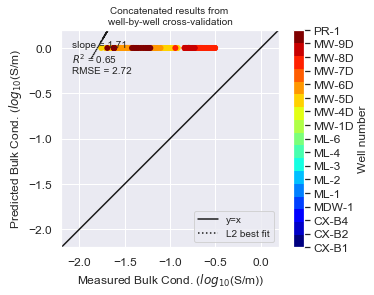

WS RMSE 0.22056364255049654


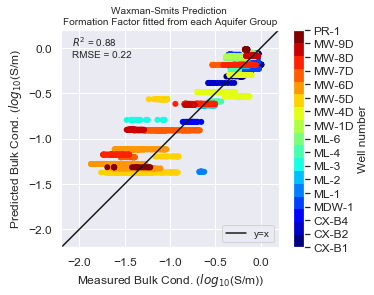

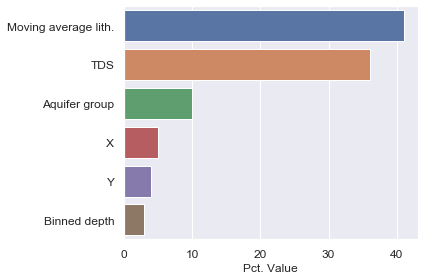

In [180]:
# #Plot 

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title




c = np.concatenate( y_color, axis=0 )
# c = [welldict[nam] for nam in df_testing.Well]
cmap = cm.get_cmap('jet',len(np.unique(c)))

y_pred = np.concatenate( y_preds, axis=0 )# + df_testing.logcild_pred_archie
y_test= df_testing.logcild

print('RF RMSE',rmse(y_pred,y_test))

f,ax = plt.subplots(1,figsize=(5,4))
plt.xlim(-2.2,.2)
plt.ylim(-2.2,.2)
ax.set_aspect('equal')
# sns.kdeplot(y_test,y_pred,n_levels=10,shade=False,shade_lowest=False)

f,ax = x_y_regression(y_test,
                      y_pred,
#                         bin_wiggle(np.concatenate( y_tests, axis=0 )),
#                       np.concatenate( y_preds, axis=0 ),                      
#                         bin_wiggle(np.concatenate( y_tests, axis=0 )),
#                       bin_wiggle(np.concatenate( y_preds, axis=0 ),binsize=.1),
                      c,
                      ax=ax,
                     errtype='RMSE',plotslp=True,
                      slpname='slope',plotone2one=True,
                      edgecolors='k',linewidth=0,cmap=cmap)

plt.xlabel('Measured Bulk Cond. ($log_{10}$(S/m))')
plt.ylabel('Predicted Bulk Cond. ($log_{10}$(S/m)')
plt.title('Concatenated results from \nwell-by-well cross-validation')
plt.legend(loc='lower right')
cb = plt.colorbar()
cb.ax.set_ylabel('Well number')
ticks=  [num for nam,num in welldict.items() if (nam in allwells)]
ticklabels = [nam for nam,num in welldict.items() if (nam in allwells)]
# ticklabels = [nam for num,nam in enumerate(aq_names)]

cb.set_ticks(ticks)
cb.set_ticklabels(ticklabels)
# sns.kdeplot(np.concatenate( y_tests, axis=0 ),bin_wiggle(np.concatenate( y_preds, axis=0 ),binsize=.1),n_levels=20,shade=False,shade_lowest=False)
# # plt.axis('off')
# plt.xlim([-1.25,2])
# plt.ylim([-1.25,2])
# plt.savefig(figdir.joinpath('RF_pred_logcild.png'),dpi=300,bbox_inches='tight')
plt.show()


# y_test = np.log10(df_testing.RILD.values)
# y_pred = df_testing.logrild_pred_ws.values
y_test    = df_testing.logcild
y_pred = df_testing.logcild_pred_archie
print('WS RMSE',rmse(y_pred,y_test))
c = np.asarray([welldict[nam] for nam in df_testing.Well])


msk=~np.isnan(y_pred)
y_test = y_test[msk]
y_pred = y_pred[msk]
c = c[msk]
cmap = cm.get_cmap('jet',len(np.unique(c)))
f,ax = plt.subplots(1,figsize=(5,4))
# sns.kdeplot(y_test,y_pred,n_levels=10,shade=False,shade_lowest=False)
plt.xlim(-2.2,.2)
plt.ylim(-2.2,.2)
ax.set_aspect('equal')

f,ax= x_y_regression(y_test,
                    y_pred,
                    c,
                    plotone2one=True,
                     ax=ax,plotslp=False,
                     errtype='RMSE',
                    slpname='slope',edgecolors='k',linewidth=0,cmap=cmap)#,vmin=25,vmax=100);

plt.xlabel('Measured Bulk Cond. ($log_{10}$(S/m))')
plt.ylabel('Predicted Bulk Cond. ($log_{10}$(S/m)')
plt.title('Waxman-Smits Prediction \nFormation Factor fitted from each Aquifer Group')
plt.legend(loc='lower right')
cb = plt.colorbar()
cb.ax.set_ylabel('Well number')
ticks=  [num for nam,num in welldict.items() if (nam in allwells)]
ticklabels = [nam for nam,num in welldict.items() if (nam in allwells)]
# ticklabels = [nam for num,nam in enumerate(aq_names)]
cb.set_ticks(ticks)
cb.set_ticklabels(ticklabels)
plt.legend(loc='lower right')
# plt.savefig(figdir.joinpath('WS_pred_logcild.png'),dpi=300,bbox_inches='tight')
plt.show()


predictor_name = ['TDS', 'Moving average lith.', 'Aquifer group', 'Binned depth', 'X', 'Y']
plt.figure()
feature_imp = pd.DataFrame(sorted(zip(np.round(100*gbm.feature_importances_/gbm.feature_importances_.sum()),predictor_name)), columns=['Pct. Value','Feature'])
sns.barplot(x="Pct. Value", y="Feature", data=feature_imp.sort_values(by="Pct. Value", ascending=False))
plt.ylabel('')
plt.tight_layout()
# plt.savefig(figdir.joinpath('FeatImportance_logcild.png'),dpi=300,bbox_inches='tight')
# export_tree(figdir,estimator.estimators_[0],max_depth=5,predictors=predictors,prefix='Tree_')

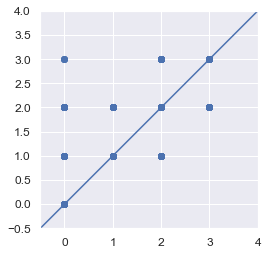

In [211]:
def update_FBS(df,TDS_col,breaks=[0,3000,10000],return_vec=False):
    FBS = 10*np.ones(len(df))
    FBS[df.loc[:,TDS_col].isna()] = np.nan
    breaks = np.r_[breaks,1e10]
    for i in range(len(breaks[:-1])):
        FBS[np.logical_and(df.loc[:,TDS_col] > breaks[i], df.loc[:,TDS_col] < breaks[i+1])] = i
    if return_vec:
        return FBS
    else:
        return df.assign(FBS=FBS)

    
    
FBS_TDS = update_FBS(df,'TDS1',breaks,return_vec=True)
FBS_archie = update_FBS(df,'TDS_pred_archie',breaks,return_vec=True)

# plt.scatter(FBS_TDS,df.TDS1)
plt.scatter(FBS_TDS,FBS_archie)

plt.xlim(-.5,4)
plt.ylim(-.5,4)
ax = plt.gca()
ax.set_aspect('equal')
plt.plot([-1,5],[-1,5])

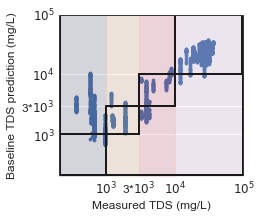

In [314]:
from matplotlib.patches import Rectangle
f,ax= plt.subplots(1,figsize=(3.33,3))
plt.ylabel('Baseline TDS prediction (mg/L)')
plt.xlabel('Measured TDS (mg/L)')
plt.xscale('log')
plt.xlim(200,100000)
plt.ylim(200,100000)
plt.yscale('log')
plt.fill([1,1,1000,1000],[1,1000000,1000000,1],  'k', alpha=0.1, edgecolor='r' )
plt.fill([1000,1000,3000,3000], [1,1000000,1000000,1], 'orange', alpha=0.1, edgecolor='r',label='TDS' )
plt.fill([3000,3000,10000,10000],[1,1000000,1000000,1],  'red', alpha=0.1, edgecolor='r',label='TDS' )
plt.fill([10000,10000,1000000,1000000],[1,1000000,1000000,1],  'pink', alpha=0.1, edgecolor='r',label='TDS' )
plt.scatter(df_testing.TDS1,df_testing.TDS_pred_archie,s=7.5,c='b')

rects =[]
rects.append(Rectangle((210,210),1000-210,1000-210,fill=False,edgecolor='k',linewidth=2))
rects.append(Rectangle((1000,1000),2000,2000,fill=False,edgecolor='k',linewidth=2))
rects.append(Rectangle((3000,3000),7000,7000,fill=False,edgecolor='k',linewidth=2))
rects.append(Rectangle((10000,10000),100000-15000,100000-15000,fill=False,edgecolor='k',linewidth=2))
rects.append(Rectangle((210,210),100000-5000,100000-5000,fill=False,edgecolor='k',linewidth=2))

for r in rects:
    ax.add_patch(r)
    
ticks = [1000,3000,10000,100000]
plt.xticks(ticks=ticks,labels=['$10^3$','3*$10^3$','$10^4$','$10^5$'],rotation=0)
plt.yticks(ticks=ticks,labels=['$10^3$','3*$10^3$','$10^4$','$10^5$'])

# plt.xticks(ticks=ticks,labels=ticks)
# plt.yticks(ticks=ticks,labels=ticks)

ax.tick_params('both', length=0, width=5, which='both',color='k')
# plt.savefig(figdir.joinpath('Baseline_FBS_Prediction.pdf'),dpi=300,bbox_inches='tight')

WS RMSE 0.22056364255049654


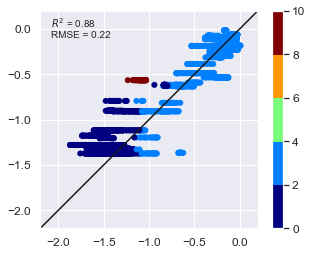

In [315]:
y_test = df_testing.logcild
y_pred = df_testing.logcild_pred_archie
print('WS RMSE',rmse(y_pred,y_test))
c = df_testing.FBS_archie.values


msk=~np.isnan(y_pred)
y_test = y_test[msk]
y_pred = y_pred[msk]
c = c[msk]
cmap = cm.get_cmap('jet',len(np.unique(c)))
f,ax = plt.subplots(1,figsize=(5,4))
# sns.kdeplot(y_test,y_pred,n_levels=10,shade=False,shade_lowest=False)
plt.xlim(-2.2,.2)
plt.ylim(-2.2,.2)
ax.set_aspect('equal')

f,ax= x_y_regression(y_test,
                    y_pred,
                    c,
                    plotone2one=True,
                     ax=ax,plotslp=False,
                     errtype='RMSE',
                    slpname='slope',edgecolors='k',linewidth=0,cmap=cmap)#,vmin=25,vmax=100);

plt.colorbar()

(-1.6, 1.6)

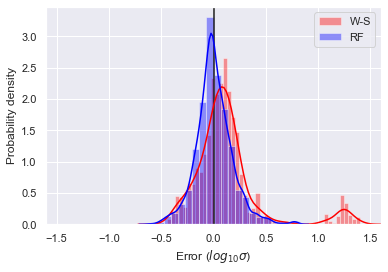

In [52]:
bins=np.linspace(-1.5,1.5,45)
# pred_err = (np.concatenate( y_preds, axis=0 ) + df_testing.logcild_pred_archie - df_testing.logcild).values
# sns.distplot(df_testing.logcild_rem,color='red',kde=True,label='W-S',bins=bins)
# sns.distplot(pred_err,kde=True,color='blue',label='RF',bins=bins)
sns.distplot((df_testing.logcild-df_testing.logcild_pred_archie),color='red',kde=True,label='W-S')
sns.distplot(df_testing.err_pred_RF,kde=True,color='blue',label='RF',bins=bins)
ylim = plt.gca().get_ylim()
plt.vlines(0,0,ylim[1])
plt.gca().set_ylim(ylim)
plt.legend()
plt.xlabel('Error ($log_{10}\sigma$)')
plt.ylabel('Probability density')
plt.xlim(-1.6,1.6)
# plt.savefig(figdir.joinpath('Err_logcild.png'),bbox_inches='tight',dpi=300)

In [53]:
# sns.pairplot(df_testing.loc[:,['logcild_rem','X','Y','aq_groupnum','lithnum_bin_conv','logcild','logcild_pred_archie']])

### Predicting FBS (Classification)

In [37]:
import lightgbm
from numpy.linalg import norm
breaks= [0,1000,3000,10000,100000]
# breaks= [0,500,1000,3000,10000,100000]
df2 = update_FBS(df2,'TDS1',breaks=breaks)
np.random.seed(1)
# loglam,logA=xin
# lam= np.exp(loglam)
# A  = np.exp(logA)
dopca=False
predicted = 'FBS'
predictors = ['logcild','logcild_pred_ws','X','Y','aq_groupnum','DEPT_bin']#<-- Case 6
predictors = ['logcild_hmean_step','logcild_pred_ws','X','Y','aq_groupnum','DEPT_bin']#<-- Case 6

y_preds = []
y_tests = []
y_color = []
y_probs = []
errs = []
estimators = []
# df_testing= resample(df2,n_samples=10000)
df_testing = df2
# df_testing = df2.assign(samp=False)
df_testing= df_testing.assign(tds_est_archie =rho2tds_est(1/df_testing.Cw_pred_archie)) 
df_testing = df_testing.assign(DEPT_bin = (np.round(df_testing.DEPT/100,0)*100).astype(np.int))
# df_testing = df_testing.assign(logrhoEC_est = np.log10(df_testing.loc[:,'Rw_est']))
df_testing = df_testing.assign(Region_bin = df_testing.loc[:,'Region']=='Marina')
df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logcondEC1f = np.log10(df_testing.loc[:,'EC1f']))
df_testing = df_testing.assign(logcond_pred_archie = np.log10(df_testing.Cw_pred_archie.values*1e4))


df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logcild_bin = np.round(np.log10(1/df_testing.RILD)*10,0))
df_testing = df_testing.assign(logcild_hmean_step = np.log10(1/np.power(10,df_testing.logrild_hmean_step)))

df_testing = df_testing.assign(logcild_hmean_bin =np.round(np.log10(1/np.power(10,df_testing.logrild_hmean_step))*10,0))
df_testing = df_testing.assign(logrild_hmean_bin =np.round(df_testing.logrild_hmean_step*10,0))

df_testing = df_testing.assign(logcild_spline_bin = np.round(df_testing.logcild_spline*10,0))
df_testing = df_testing.assign(logcild = np.log10(1/df_testing.RILD))
df_testing = df_testing.assign(logcild_pred_ws = np.log10(1/np.power(10,df_testing.logrild_pred_ws)))
df_testing = df_testing.assign(logcild_pred_ws_B = np.log10(1/np.power(10,df_testing.logrild_pred_ws_B)))

df_testing = df_testing.assign(logcond_pred_EC_archie = np.log10(1/np.power(10,df_testing.Cw_pred_archie*1e4)))

df_testing = df_testing.assign(err_ws = np.abs(np.log10(1/df_testing.RILD) - df_testing.logcild_pred_ws))

df_testing = df_testing.assign(cild_bin = np.round(1/df2.RILD*10,0))
df_testing = df_testing.assign(cond_est = 1/tds2rho_est(df2.TDS1))
df_testing = df_testing.assign(cond_est_bin = np.round( (df_testing.cond_est /1).astype(np.float),0)*1)
df_testing = df_testing.assign(logcond_est = np.log10((df_testing.cond_est).astype(np.float) ))
df_testing = df_testing.assign(logrhoEC_est = np.log10(tds2rho_est(df_testing.TDS1).astype(np.float)))
df_testing = df_testing.assign(logcondEC_est = np.log10(1/(tds2rho_est(df_testing.TDS1).astype(np.float))))

df_testing = df_testing.assign(logrild_conv_bin = (np.round(df_testing.logrild_conv,1)*10).values.astype(int))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))
df_testing= df_testing.assign(tds_est_archie = EC1f2tds(df_testing.Cw_pred_archie*1e4))
df_testing= df_testing.assign(FBS_est_archie =  update_FBS(df_testing,'tds_est_archie',breaks,return_vec=True).astype(np.int)) 
df_testing= df_testing.assign(FBS_est_archie2 =  update_FBS(df_testing,'TDS_pred_archie',breaks,return_vec=True).astype(np.int)) 

list_of_conditions = (df2.RILD.notnull(),
                      df2.FBS.notnull(),
                      df2.lith.notnull(),
                      df2.Y.notnull(),
                      df2.Region=='Marina')
conditions = [df_testing.loc[:,predictor].notnull() for predictor in predictors]
df_testing = df_testing.loc[nested_logicals(df_testing,list_of_conditions,func=np.logical_and)]
# df_testing = df_testing.loc[df_testing.lithnum_bin_conv==1,:]

# # # ##### Standardize, PCA
if dopca:
    data = df_testing.loc[:,predictors]
    df_testing,predictors = standardize_pca(data,pcaobj=pcaobj, n_components=n_components,df_concat=df_testing)
# df_testing,predictors = standardize(data,colnames=predictors,df_concat=df_testing)

# updating objective function to custom
# default is "regression"
# also adding metrics to check different scores


allwells = df_testing.Well.unique()
for nam in allwells:
    lam= np.exp(-0.96940507)
    A = np.exp(1.72721597)  
    A=100000

#     A=2.5
    lam=.09
    cutoff=  -0.49481258
    learn = 0.06
    reg_lambda=0#.5
    reg_alpha=0
    early_stopping_rounds=10

    
    
    
    testwell = nam
    trainwells = [wellid for wellid in allwells if wellid!=testwell]

    df_train = df_testing.loc[df_testing.Well.isin(trainwells)]
    df_test = df_testing.loc[df_testing.Well==testwell]

    X_train = df_train.loc[:,predictors].values
    y_train = df_train.loc[:,predicted]
    X_valid = df_test.loc[:,predictors].values
    y_valid = df_test.loc[:,predicted]
    weight=np.where(df_train.FBS.isin((1,2)),10,1)

    def custom_asymmetric_train(y_true, y_pred):
        residual = (y_true - y_pred).astype("float")
        y_ws = rho2tds_est(df_train.tds_est_archie).values
        grad = np.where(residual>0, -2*A*residual, -2*residual) - 2*lam*(y_ws- y_pred)
        hess = np.where(residual>0, 2*A, 2.0) + 2*lam
        return grad, hess

    def logregobj(y_true, y_pred):
        y_pred = 1.0 / (1.0 + np.exp(-y_pred))
        grad = y_pred - y_true
        hess = y_pred * (1.0 - y_pred)
        return grad, hess    
    
    
#     predictions = np.array([[0.25,0.25,0.25,0.25],
#                             [0.01,0.01,0.01,0.96]])
#     targets = np.array([[0,0,0,1],
#                        [0,0,0,1]])
    
#     def cross_entropy(targets,predictions):
#         epsilon=1e-10
#         predictions = np.clip(predictions, epsilon, 1. - epsilon)
#         N = predictions.shape[0]
#         ce_loss = -np.sum(np.sum(targets * np.log(predictions + 1e-5)))/N
#         return ce_loss    
    
    def custom_asymmetric_valid(y_true, y_pred):
        residual = (y_true - y_pred).astype("float")
#         y_ws = df_test.logcild_pred_ws.values
        y_ws = np.log10(df_test.Cw_pred_archie.values*1e4)
        loss = np.where(residual>0, A*residual**2, residual**2) + lam*(y_ws- y_pred)**2
        return "custom_asymmetric_eval", np.mean(loss), False



#     gbm = lightgbm.LGBMRegressor(num_iterations=100,
#                              boosting_type='gbdt',
#                              learning_rate=learn,
#                              max_depth=-1,
#                              reg_lambda=reg_lambda,
#                              reg_alpha=reg_alpha,
#                              max_bin=500,
#                              num_leaves=10) 
    gbm = lightgbm.LGBMClassifier(
                             n_estimators=100,
                             boosting_type='dart',
                             learning_rate=learn,
                             max_depth=-1,
                             reg_lambda=1,
                             reg_alpha=.75,
                             max_bin=500,
                             num_leaves=10) 
    gbm.set_params(**{'objective': 'multiclass',
                      "num_class" : 4,
                      'metric': 'multi_logloss',
                      'feature_fraction': 0.9,
                       'bagging_fraction': 0.6,
                      'bagging_freq': 5
                     })
    
    # fitting model 
    gbm.fit(
        X_train,
        y_train,
#         eval_set=[(X_valid, y_valid)],
#         eval_metric=custom_asymmetric_valid,
        sample_weight=weight,
        verbose=False,
        feature_name=predictors,
#         categorical_feature=['FBS_est_archie']
    )
    y_pred = gbm.predict(X_valid)

    y_probs.append(gbm.predict_proba(X_valid))
    y_tests.append(y_valid)
    y_preds.append(y_pred)
    y_color.append([welldict[nam] for nam in df_test.Well])
    estimators.append(gbm)
    print('testing on',nam,
          'no. samples:',len(X_train),
          '\ttest size:',len(X_valid),
          '\tNormErr:',np.round(100*norm(y_valid-y_pred)/norm(y_valid),4),'%',
          '\tRMSE:',np.round(rmse(y_valid,y_pred),3),
          '\tLambda:',np.round(lam,2),
          '\tA:',np.round(A,2))


y_pred_RF = np.log10(np.power(10,np.concatenate( y_preds, axis=0 ))/1e4)
y_test = np.log10(df_testing.EC1f/1e4)

err = (y_test-y_pred_RF)
df_testing = df_testing.assign(err_pred_EC_RF= err)
print('RMSE',np.round(rmse(y_test,y_pred_RF),3),
      '\tA:',A,
      '\tlam',lam,
     '\tCutoff:',cutoff)
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,f1_score
conf=confusion_matrix(np.concatenate( y_tests, axis=0 ),np.concatenate( y_preds, axis=0 ),labels=[0., 1., 2., 3.])
print('accuracy:',np.sum(np.diag(conf))/np.sum(conf))


/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log10
/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in power
/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log10
/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in log10


testing on CX-B1 no. samples: 2932 	test size: 120 	NormErr: 0.0 % 	RMSE: 0.0 	Lambda: 0.09 	A: 100000
testing on CX-B2 no. samples: 2972 	test size: 80 	NormErr: 0.0 % 	RMSE: 0.0 	Lambda: 0.09 	A: 100000
testing on CX-B4 no. samples: 2952 	test size: 100 	NormErr: 0.0 % 	RMSE: 0.0 	Lambda: 0.09 	A: 100000
testing on MDW-1 no. samples: 2972 	test size: 80 	NormErr: 0.0 % 	RMSE: 0.0 	Lambda: 0.09 	A: 100000
testing on ML-1 no. samples: 3022 	test size: 30 	NormErr: 68.5994 % 	RMSE: 1.633 	Lambda: 0.09 	A: 100000
testing on ML-2 no. samples: 3012 	test size: 40 	NormErr: 0.0 % 	RMSE: 0.0 	Lambda: 0.09 	A: 100000
testing on ML-3 no. samples: 3012 	test size: 40 	NormErr: 0.0 % 	RMSE: 0.0 	Lambda: 0.09 	A: 100000
testing on ML-4 no. samples: 3012 	test size: 40 	NormErr: 18.6052 % 	RMSE: 0.474 	Lambda: 0.09 	A: 100000
testing on ML-6 no. samples: 3012 	test size: 40 	NormErr: 0.0 % 	RMSE: 0.0 	Lambda: 0.09 	A: 100000
testing on MW-1D no. samples: 2745 	test size: 307 	NormErr: 0.0 % 	RMSE:

RF:
accuracy:	 0.93
nmean score:	 0.93 
Class2 score:	 0.96 
scores:	 [[0.85 1.   0.92 0.96]]


Archie:
Accuracy:	 0.57 
mean score:	 0.57 
Class2 score:	 0.41 
scores:	 [[0.48 0.44 0.34 1.  ]]


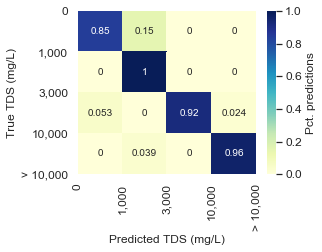

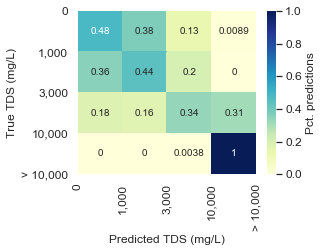

In [318]:
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,f1_score


ticks = sorted(df_testing.FBS.unique())
labels = ['{:,}'.format(b) for b in breaks]
labels[-1]="$\infty$"
labels[-1]="> 10,000"

conf=confusion_matrix(np.concatenate( y_tests, axis=0 ),
                      np.concatenate( y_preds, axis=0 ),labels=ticks)
conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]


y_prob_2 = np.concatenate(y_probs,axis=0)[:,2]
y_pred_2 = np.where(np.concatenate( y_preds, axis=0 )==2, 1,0)
y_true_2 = np.where(np.concatenate( y_tests, axis=0 )==2, 1,0)
f1_RF= f1_score(y_true_2,y_pred_2)




df_testing= df_testing.assign(tds_est_archie = EC1f2tds(df_testing.Cw_pred_archie*1e4))
conf_archie=confusion_matrix(np.concatenate( y_tests, axis=0 ),
                             df_testing.FBS_est_archie.values,
                             labels=ticks)
conf_archie = conf_archie.astype('float') / conf_archie.sum(axis=1)[:, np.newaxis]


y_pred_archie_2 = np.where( df_testing.FBS_est_archie.values==2, 1,0)
y_true_archie_2 = np.where(np.concatenate( y_tests, axis=0 )==2, 1,0)

f1_archie = f1_score(y_pred_archie_2,y_true_archie_2)


score = np.diag(conf)/conf.sum(axis=1)[:, np.newaxis].T
print('RF:\naccuracy:\t',np.round(np.sum(np.diag(conf))/np.sum(conf),2))
print('nmean score:\t',np.round(np.mean(score),2),
     '\nClass2 score:\t',np.round(f1_RF,2),
     '\nscores:\t',np.round(score,2))


print('\n')
score = np.diag(conf_archie)/conf_archie.sum(axis=1)[:, np.newaxis].T
print('Archie:\nAccuracy:\t',np.round(np.sum(np.diag(conf_archie))/np.sum(conf_archie),2),
      '\nmean score:\t',np.round(np.mean(score),2),
     '\nClass2 score:\t',np.round(f1_archie,2),
     '\nscores:\t',np.round(score,2))

f,ax=plt.subplots(1,figsize=(4,3))
cmap = sns.cubehelix_palette(n_colors=4,as_cmap=True)
sns.heatmap(conf,cmap="YlGnBu",vmin=0,vmax=1,cbar_kws={'label': 'Pct. predictions'},annot=True,ax=ax,linewidth=0,linecolor='black')
t = plt.xticks()
plt.xticks(np.r_[ticks,max(ticks)+1],labels,rotation=90)
plt.yticks(np.r_[ticks,max(ticks)+1],labels,rotation=0)
plt.ylabel('True TDS (mg/L)')
plt.xlabel('Predicted TDS (mg/L)')
plt.savefig(figdir.joinpath('ConfMat_RF.png'),bbox_inches='tight',dpi=300)
plt.show()


f,ax=plt.subplots(1,figsize=(4,3))
sns.heatmap(conf_archie,cmap="YlGnBu",vmin=0,vmax=1,cbar_kws={'label': 'Pct. predictions'},annot=True,ax=ax,linewidth=0,linecolor='black')
plt.xticks(np.r_[ticks,max(ticks)+1],labels,rotation=90)
plt.yticks(np.r_[ticks,max(ticks)+1],labels,rotation=0)
plt.ylabel('True TDS (mg/L)')
plt.xlabel('Predicted TDS (mg/L)')
plt.savefig(figdir.joinpath('ConfMat_Archie.png'),bbox_inches='tight',dpi=300)
plt.show()

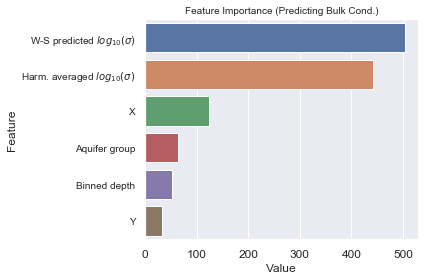

In [78]:
predictors_full = ['Harm. averaged $log_{10}(\sigma)$', 'W-S predicted $log_{10}(\sigma)$', 'X', 'Y', 'Aquifer group', 'Binned depth']
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importances_,predictors_full)), columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature Importance (Predicting Bulk Cond.)')
plt.tight_layout()
plt.savefig(figdir.joinpath('FeatImportance_FBS.png'),dpi=300,bbox_inches='tight')


### Customizing softmax objective function 

In [12]:
import lightgbm
from numpy.linalg import norm
breaks= [0,1000,3000,10000,100000]
# breaks= [0,500,1000,3000,10000,100000]
df2 = update_FBS(df2,'TDS1',breaks=breaks)
np.random.seed(1)
# loglam,logA=xin
# lam= np.exp(loglam)
# A  = np.exp(logA)
dopca=False
predicted = 'FBS'
predictors = ['logcild','logcild_pred_ws','X','Y','aq_groupnum','DEPT_bin']#<-- Case 6
predictors = ['logcild_hmean_step','logcild_pred_ws','X','Y','aq_groupnum','DEPT_bin']#<-- Case 6

y_preds = []
y_tests = []
y_color = []
y_probs = []
errs = []
estimators = []
# df_testing= resample(df2,n_samples=10000)
df_testing = df2
# df_testing = df2.assign(samp=False)
df_testing= df_testing.assign(tds_est_archie =rho2tds_est(1/df_testing.Cw_pred_archie)) 
df_testing = df_testing.assign(DEPT_bin = (np.round(df_testing.DEPT/100,0)*100).astype(np.int))
# df_testing = df_testing.assign(logrhoEC_est = np.log10(df_testing.loc[:,'Rw_est']))
df_testing = df_testing.assign(Region_bin = df_testing.loc[:,'Region']=='Marina')
df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logcondEC1f = np.log10(df_testing.loc[:,'EC1f']))
df_testing = df_testing.assign(logcond_pred_archie = np.log10(df_testing.Cw_pred_archie.values*1e4))


df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logcild_bin = np.round(np.log10(1/df_testing.RILD)*10,0))
df_testing = df_testing.assign(logcild_hmean_step = np.log10(1/np.power(10,df_testing.logrild_hmean_step)))

df_testing = df_testing.assign(logcild_hmean_bin =np.round(np.log10(1/np.power(10,df_testing.logrild_hmean_step))*10,0))
df_testing = df_testing.assign(logrild_hmean_bin =np.round(df_testing.logrild_hmean_step*10,0))

df_testing = df_testing.assign(logcild_spline_bin = np.round(df_testing.logcild_spline*10,0))
df_testing = df_testing.assign(logcild = np.log10(1/df_testing.RILD))
df_testing = df_testing.assign(logcild_pred_ws = np.log10(1/np.power(10,df_testing.logrild_pred_ws)))
df_testing = df_testing.assign(logcild_pred_ws_B = np.log10(1/np.power(10,df_testing.logrild_pred_ws_B)))

df_testing = df_testing.assign(logcond_pred_EC_archie = np.log10(1/np.power(10,df_testing.Cw_pred_archie*1e4)))

df_testing = df_testing.assign(err_ws = np.abs(np.log10(1/df_testing.RILD) - df_testing.logcild_pred_ws))

df_testing = df_testing.assign(cild_bin = np.round(1/df2.RILD*10,0))
df_testing = df_testing.assign(cond_est = 1/tds2rho_est(df2.TDS1))
df_testing = df_testing.assign(cond_est_bin = np.round( (df_testing.cond_est /1).astype(np.float),0)*1)
df_testing = df_testing.assign(logcond_est = np.log10((df_testing.cond_est).astype(np.float) ))
df_testing = df_testing.assign(logrhoEC_est = np.log10(tds2rho_est(df_testing.TDS1).astype(np.float)))
df_testing = df_testing.assign(logcondEC_est = np.log10(1/(tds2rho_est(df_testing.TDS1).astype(np.float))))

df_testing = df_testing.assign(logrild_conv_bin = (np.round(df_testing.logrild_conv,1)*10).values.astype(int))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))
df_testing= df_testing.assign(tds_est_archie = EC1f2tds(df_testing.Cw_pred_archie*1e4))
df_testing= df_testing.assign(FBS_est_archie =  update_FBS(df_testing,'tds_est_archie',breaks,return_vec=True).astype(np.int)) 
df_testing= df_testing.assign(FBS_est_archie2 =  update_FBS(df_testing,'TDS_pred_archie',breaks,return_vec=True).astype(np.int)) 

list_of_conditions = (df2.RILD.notnull(),
                      df2.FBS.notnull(),
                      df2.lith.notnull(),
                      df2.Y.notnull(),
                      df2.Region=='Marina')
conditions = [df_testing.loc[:,predictor].notnull() for predictor in predictors]
df_testing = df_testing.loc[nested_logicals(df_testing,list_of_conditions,func=np.logical_and)]
# df_testing = df_testing.loc[df_testing.lithnum_bin_conv==1,:]

# # # ##### Standardize, PCA
if dopca:
    data = df_testing.loc[:,predictors]
    df_testing,predictors = standardize_pca(data,pcaobj=pcaobj, n_components=n_components,df_concat=df_testing)
# df_testing,predictors = standardize(data,colnames=predictors,df_concat=df_testing)

# updating objective function to custom
# default is "regression"
# also adding metrics to check different scores


allwells = df_testing.Well.unique()
for nam in allwells:
    lam= np.exp(-0.96940507)
    A = np.exp(1.72721597)  
    A=100000

#     A=2.5
    lam=.09
    cutoff=  -0.49481258
    learn = 0.06
    reg_lambda=0#.5
    reg_alpha=0
    early_stopping_rounds=10

    
    
    
    testwell = nam
    trainwells = [wellid for wellid in allwells if wellid!=testwell]

    df_train = df_testing.loc[df_testing.Well.isin(trainwells)]
    df_test = df_testing.loc[df_testing.Well==testwell]

    X_train = df_train.loc[:,predictors].values
    y_train = df_train.loc[:,predicted]
    X_valid = df_test.loc[:,predictors].values
    y_valid = df_test.loc[:,predicted]
    weight=np.where(df_train.FBS.isin((1,2)),10,1)

    




#     predictions = np.array([[0.25,0.25,0.25,0.25],
#                             [0.01,0.01,0.01,0.96]])
#     targets = np.array([[0,0,0,1],
#                        [0,0,0,1]])
    
#     def cross_entropy(targets,predictions):
#         epsilon=1e-10
#         predictions = np.clip(predictions, epsilon, 1. - epsilon)
#         N = predictions.shape[0]
#         ce_loss = -np.sum(np.sum(targets * np.log(predictions + 1e-5)))/N
#         return ce_loss    
    
    def custom_asymmetric_valid(y_true, y_pred):
        residual = (y_true - y_pred).astype("float")
#         y_ws = df_test.logcild_pred_ws.values
        y_ws = np.log10(df_test.Cw_pred_archie.values*1e4)
        loss = np.where(residual>0, A*residual**2, residual**2) + lam*(y_ws- y_pred)**2
        return "custom_asymmetric_eval", np.mean(loss), False



#     gbm = lightgbm.LGBMRegressor(num_iterations=100,
#                              boosting_type='gbdt',
#                              learning_rate=learn,
#                              max_depth=-1,
#                              reg_lambda=reg_lambda,
#                              reg_alpha=reg_alpha,
#                              max_bin=500,
#                              num_leaves=10) 
    gbm = lightgbm.LGBMClassifier(
                             n_estimators=100,
                             boosting_type='dart',
                             learning_rate=learn,
                             max_depth=-1,
                             reg_lambda=1,
                             reg_alpha=.75,
                             max_bin=500,
                             num_leaves=10) 
    gbm.set_params(**{'objective': 'multiclass',
                      "num_class" : 4,
                      'metric': 'multi_logloss',
                      'feature_fraction': 0.9,
                       'bagging_fraction': 0.6,
                      'bagging_freq': 5
                     })
    
    # fitting model 
    gbm.fit(
        X_train,
        y_train,
#         eval_set=[(X_valid, y_valid)],
#         eval_metric=custom_asymmetric_valid,
        sample_weight=weight,
        verbose=False,
        feature_name=predictors,
#         categorical_feature=['FBS_est_archie']
    )
    y_pred = gbm.predict(X_valid)

    y_probs.append(gbm.predict_proba(X_valid))
    y_tests.append(y_valid)
    y_preds.append(y_pred)
    y_color.append([welldict[nam] for nam in df_test.Well])
    estimators.append(gbm)
    print('testing on',nam,
          'no. samples:',len(X_train),
          '\ttest size:',len(X_valid),
          '\tNormErr:',np.round(100*norm(y_valid-y_pred)/norm(y_valid),4),'%',
          '\tRMSE:',np.round(rmse(y_valid,y_pred),3),
          '\tLambda:',np.round(lam,2),
          '\tA:',np.round(A,2))


y_pred_RF = np.log10(np.power(10,np.concatenate( y_preds, axis=0 ))/1e4)
y_test = np.log10(df_testing.EC1f/1e4)

err = (y_test-y_pred_RF)
df_testing = df_testing.assign(err_pred_EC_RF= err)
print('RMSE',np.round(rmse(y_test,y_pred_RF),3),
      '\tA:',A,
      '\tlam',lam,
     '\tCutoff:',cutoff)
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,f1_score
conf=confusion_matrix(np.concatenate( y_tests, axis=0 ),np.concatenate( y_preds, axis=0 ),labels=[0., 1., 2., 3.])
print('accuracy:',np.sum(np.diag(conf))/np.sum(conf))


/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log10
/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in power
/Users/ianpg/a

testing on CX-B1 no. samples: 2932 	test size: 120 	NormErr: 0.0 % 	RMSE: 0.0 	Lambda: 0.09 	A: 100000
testing on CX-B2 no. samples: 2972 	test size: 80 	NormErr: 0.0 % 	RMSE: 0.0 	Lambda: 0.09 	A: 100000
testing on CX-B4 no. samples: 2952 	test size: 100 	NormErr: 0.0 % 	RMSE: 0.0 	Lambda: 0.09 	A: 100000
testing on MDW-1 no. samples: 2972 	test size: 80 	NormErr: 0.0 % 	RMSE: 0.0 	Lambda: 0.09 	A: 100000
testing on ML-1 no. samples: 3022 	test size: 30 	NormErr: 68.5994 % 	RMSE: 1.633 	Lambda: 0.09 	A: 100000
testing on ML-2 no. samples: 3012 	test size: 40 	NormErr: 0.0 % 	RMSE: 0.0 	Lambda: 0.09 	A: 100000
testing on ML-3 no. samples: 3012 	test size: 40 	NormErr: 0.0 % 	RMSE: 0.0 	Lambda: 0.09 	A: 100000
testing on ML-4 no. samples: 3012 	test size: 40 	NormErr: 18.6052 % 	RMSE: 0.474 	Lambda: 0.09 	A: 100000
testing on ML-6 no. samples: 3012 	test size: 40 	NormErr: 0.0 % 	RMSE: 0.0 	Lambda: 0.09 	A: 100000
testing on MW-1D no. samples: 2745 	test size: 307 	NormErr: 0.0 % 	RMSE:

In [48]:
import scipy.sparse
def getLoss(w,x,y,lam):
    m = x.shape[0] #First we get the number of training examples
    y_mat = oneHotIt(y) #Next we convert the integer class coding into a one-hot representation
    scores = np.dot(x,w) #Then we compute raw class scores given our input and current weights
    prob = softmax(scores) #Next we perform a softmax on these scores to get their probabilities
    loss = (-1 / m) * np.sum(y_mat * np.log(prob)) + (lam/2)*np.sum(w*w) #We then find the loss of the probabilities
    grad = (-1 / m) * np.dot(x.T,(y_mat - prob)) + lam*w #And compute the gradient for that loss
    return loss,grad

def oneHotIt(Y):
    m = Y.shape[0]
    #Y = Y[:,0]
    OHX = scipy.sparse.csr_matrix((np.ones(m), (Y, np.array(range(m)))))
    OHX = np.array(OHX.todense()).T
    return OHX
def softmax(z):
    z -= np.max(z)
    sm = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
    return sm
def getProbsAndPreds(someX):
    probs = softmax(np.dot(someX,w))
    preds = np.argmax(probs,axis=1)
    return probs,preds



x=X_train
y = y_train.astype(np.int)
w = np.zeros([x.shape[1],len(np.unique(y))])
lam = 1
iterations = 10
learningRate = 1e-5
losses = []
loss,grad = getLoss(w,x,y,lam)
losses.append(loss)
w = w - (learningRate * grad)
print(loss)

def logit(x,w=1):
    return 1/(1+np.exp(-np.dot(w,x)))
x=np.linspace(-10,10,100)
w=np.ones(x.shape)
w[50:] = 0
logit(x,w)

1.3862943611198906


2.1363690963621994e-110

In [51]:
grad.shape

(6, 4)

In [578]:
def EC1f2tds(EC1f,slope=0.6906,intercept=282.469):
    return EC1f*slope + intercept

# def CwArchie2tds(CwArchie,)

# # plt.scatter(df_testing.Cw_pred_archie*1e4,df_testing.TDS1)
# plt.plot(df_testing.EC1f,EC1f2tds(df_testing.EC1f),c='k')
# msk=~df_testing.Cw_pred_archie.isna()
# x_y_regression(,'k')
slope, intercept, r_value, p_value, std_err = stats.linregress(df_testing.Cw_pred_archie.values.astype('float'),
                                                               df_testing.TDS1.values.astype('float'))


5868.18919386707

### Predicting Water Conductivity

In [168]:
import lightgbm
from numpy.linalg import norm
df2 = update_FBS(df2,'TDS1',[0,1000,3000,10000,100000])
np.random.seed(1)
# loglam,logA=xin
# lam= np.exp(loglam)
# A  = np.exp(logA)
dopca=False
predicted = 'logcondEC1f'
predictors = ['logcild_pred_ws','logcild','X','Y','aq_groupnum','DEPT_bin']#<-- Case 6

y_preds = []
y_tests = []
y_color = []
errs = []
estimators = []
# df_testing= resample(df2,n_samples=10000)
df_testing = df2
# df_testing = df2.assign(samp=False)

df_testing = df_testing.assign(DEPT_bin = (np.round(df_testing.DEPT/100,0)*100).astype(np.int))
# df_testing = df_testing.assign(logrhoEC_est = np.log10(df_testing.loc[:,'Rw_est']))
df_testing = df_testing.assign(Region_bin = df_testing.loc[:,'Region']=='Marina')
df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logcondEC1f = np.log10(df_testing.loc[:,'EC1f']))
df_testing = df_testing.assign(logcond_pred_archie = np.log10(df_testing.Cw_pred_archie.values*1e4))


df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logcild_bin = np.round(np.log10(1/df_testing.RILD)*10,0))
df_testing = df_testing.assign(logcild_hmean_step = np.log10(1/np.power(10,df_testing.logrild_hmean_step)))

df_testing = df_testing.assign(logcild_hmean_bin =np.round(np.log10(1/np.power(10,df_testing.logrild_hmean_step))*10,0))
df_testing = df_testing.assign(logrild_hmean_bin =np.round(df_testing.logrild_hmean_step*10,0))

df_testing = df_testing.assign(logcild_spline_bin = np.round(df_testing.logcild_spline*10,0))
df_testing = df_testing.assign(logcild = np.log10(1/df_testing.RILD))
df_testing = df_testing.assign(logcild_pred_ws = np.log10(1/np.power(10,df_testing.logrild_pred_ws)))
df_testing = df_testing.assign(logcond_pred_EC_archie = np.log10(1/np.power(10,df_testing.Cw_pred_archie*1e4)))

df_testing = df_testing.assign(err_ws = np.abs(np.log10(1/df_testing.RILD) - df_testing.logcild_pred_ws))

df_testing = df_testing.assign(cild_bin = np.round(1/df2.RILD*10,0))
df_testing = df_testing.assign(cond_est = 1/tds2rho_est(df2.TDS1))
df_testing = df_testing.assign(cond_est_bin = np.round( (df_testing.cond_est /1).astype(np.float),0)*1)
df_testing = df_testing.assign(logcond_est = np.log10((df_testing.cond_est).astype(np.float) ))
df_testing = df_testing.assign(logrhoEC_est = np.log10(tds2rho_est(df_testing.TDS1).astype(np.float)))
df_testing = df_testing.assign(logcondEC_est = np.log10(1/(tds2rho_est(df_testing.TDS1).astype(np.float))))

df_testing = df_testing.assign(logrild_conv_bin = (np.round(df_testing.logrild_conv,1)*10).values.astype(int))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))

list_of_conditions = (df2.RILD.notnull(),
                      df2.FBS.notnull(),
                      df2.lith.notnull(),
                      df2.Y.notnull(),
                      df2.Region=='Marina')
conditions = [df_testing.loc[:,predictor].notnull() for predictor in predictors]
df_testing = df_testing.loc[nested_logicals(df_testing,list_of_conditions,func=np.logical_and)]
# df_testing = df_testing.loc[df_testing.lithnum_bin_conv==1,:]

# # # ##### Standardize, PCA
if dopca:
    data = df_testing.loc[:,predictors]
    df_testing,predictors = standardize_pca(data,pcaobj=pcaobj, n_components=n_components,df_concat=df_testing)
# df_testing,predictors = standardize(data,colnames=predictors,df_concat=df_testing)

# updating objective function to custom
# default is "regression"
# also adding metrics to check different scores


allwells = df_testing.Well.unique()
for nam in allwells:
    lam= np.exp(-0.96940507)
    A = np.exp(1.72721597)  
    A=100000

    A=2.5
    lam=.09
    cutoff=  -0.49481258
    learn = 0.06
    reg_lambda=0#.5
    reg_alpha=0
    early_stopping_rounds=10
    
    
    testwell = nam
    trainwells = [wellid for wellid in allwells if wellid!=testwell]

    df_train = df_testing.loc[df_testing.Well.isin(trainwells)]
    df_test = df_testing.loc[df_testing.Well==testwell]

    X_train = df_train.loc[:,predictors].values
    y_train = df_train.loc[:,predicted]
    X_valid = df_test.loc[:,predictors].values
    y_valid = df_test.loc[:,predicted]

    def custom_asymmetric_train(y_true, y_pred):
        residual = (y_true - y_pred).astype("float")
#         y_ws = df_train.logcild_pred_ws.values
#         y_ws = rho2tds_est(df_train.RILD).values
        y_ws = np.log10(df_train.Cw_pred_archie.values*1e4)
        grad = np.where(residual>0, -2*A*residual, -2*residual) - 2*lam*(y_ws- y_pred)
        hess = np.where(residual>0, 2*A, 2.0) + 2*lam
        return grad, hess

    def custom_asymmetric_valid(y_true, y_pred):
        residual = (y_true - y_pred).astype("float")
#         y_ws = df_test.logcild_pred_ws.values
        y_ws = np.log10(df_test.Cw_pred_archie.values*1e4)
        loss = np.where(residual>0, A*residual**2, residual**2) + lam*(y_ws- y_pred)**2
        return "custom_asymmetric_eval", np.mean(loss), False


    gbm = lightgbm.LGBMRegressor(num_iterations=100,
                             boosting_type='gbdt',
                             learning_rate=learn,
                             max_depth=-1,
                             reg_lambda=reg_lambda,
                             reg_alpha=reg_alpha,
                             max_bin=500,
                             num_leaves=10) 

    gbm.set_params(**{'objective': custom_asymmetric_train}, metrics = ["mse", 'mae'])
    
    # fitting model 
    gbm.fit(
        X_train,
        y_train,
#         eval_set=[(X_valid, y_valid)],
#         eval_metric=custom_asymmetric_valid,
        verbose=False,
#         categorical_feature=[3,4,5,6]
    )
    y_pred = gbm.predict(X_valid)

    y_tests.append(y_valid)
    y_preds.append(y_pred)
    y_color.append([welldict[nam] for nam in df_test.Well])
    estimators.append(gbm)
    print('testing on',nam,
          'no. samples:',len(X_train),
          '\ttest size:',len(X_valid),
          '\tNormErr:',np.round(100*norm(y_valid-y_pred)/norm(y_valid),4),'%',
          '\tRMSE:',np.round(rmse(y_valid,y_pred),3),
          '\tLambda:',np.round(lam,2),
          '\tA:',np.round(A,2))


y_pred_RF = np.log10(np.power(10,np.concatenate( y_preds, axis=0 ))/1e4)
y_test = np.log10(df_testing.EC1f/1e4)

err = (y_test-y_pred_RF)
df_testing = df_testing.assign(err_pred_EC_RF= err)
print('RMSE',np.round(rmse(y_test,y_pred_RF),3),
      '\tA:',A,
      '\tlam',lam,
     '\tCutoff:',cutoff)

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log10
/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in power
/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log10
/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in log10
/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in log10
/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in log10
/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in log10


testing on CX-B1 no. samples: 2932 	test size: 120 	NormErr: 100.0 % 	RMSE: 4.564 	Lambda: 0.09 	A: 2.5
testing on CX-B2 no. samples: 2972 	test size: 80 	NormErr: 100.0 % 	RMSE: 4.522 	Lambda: 0.09 	A: 2.5
testing on CX-B4 no. samples: 2952 	test size: 100 	NormErr: 100.0 % 	RMSE: 4.396 	Lambda: 0.09 	A: 2.5
testing on MDW-1 no. samples: 2972 	test size: 80 	NormErr: 100.0 % 	RMSE: 4.594 	Lambda: 0.09 	A: 2.5


/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in log10
/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in log10


testing on ML-1 no. samples: 3022 	test size: 30 	NormErr: 100.0 % 	RMSE: 3.487 	Lambda: 0.09 	A: 2.5


/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in log10


testing on ML-2 no. samples: 3012 	test size: 40 	NormErr: 100.0 % 	RMSE: 4.308 	Lambda: 0.09 	A: 2.5
testing on ML-3 no. samples: 3012 	test size: 40 	NormErr: 100.0 % 	RMSE: 3.971 	Lambda: 0.09 	A: 2.5


/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in log10
/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in log10


testing on ML-4 no. samples: 3012 	test size: 40 	NormErr: 100.0 % 	RMSE: 4.303 	Lambda: 0.09 	A: 2.5
testing on ML-6 no. samples: 3012 	test size: 40 	NormErr: 100.0 % 	RMSE: 4.656 	Lambda: 0.09 	A: 2.5


/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in log10
/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in log10


testing on MW-1D no. samples: 2745 	test size: 307 	NormErr: 100.0 % 	RMSE: 4.633 	Lambda: 0.09 	A: 2.5
testing on MW-4D no. samples: 2651 	test size: 401 	NormErr: 100.0 % 	RMSE: 4.293 	Lambda: 0.09 	A: 2.5


/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in log10
/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in log10


testing on MW-5D no. samples: 2552 	test size: 500 	NormErr: 100.0 % 	RMSE: 3.078 	Lambda: 0.09 	A: 2.5
testing on MW-6D no. samples: 2752 	test size: 300 	NormErr: 100.0 % 	RMSE: 3.284 	Lambda: 0.09 	A: 2.5


/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in log10
/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in log10


testing on MW-7D no. samples: 2754 	test size: 298 	NormErr: 100.0 % 	RMSE: 4.021 	Lambda: 0.09 	A: 2.5


/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in log10
/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in log10


testing on MW-8D no. samples: 2723 	test size: 329 	NormErr: 100.0 % 	RMSE: 3.855 	Lambda: 0.09 	A: 2.5
testing on MW-9D no. samples: 2745 	test size: 307 	NormErr: 100.0 % 	RMSE: 4.01 	Lambda: 0.09 	A: 2.5
testing on PR-1 no. samples: 3012 	test size: 40 	NormErr: 100.0 % 	RMSE: 4.003 	Lambda: 0.09 	A: 2.5
RMSE 3.98 	A: 2.5 	lam 0.09 	Cutoff: -0.49481258


/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in log10


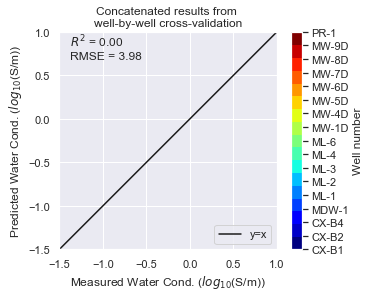

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in log10


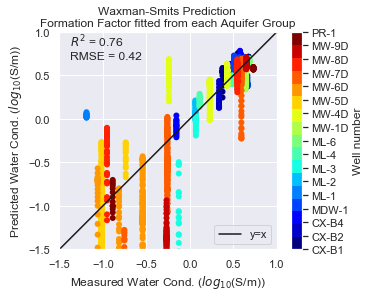

RMSE_WS 0.41925208202747716


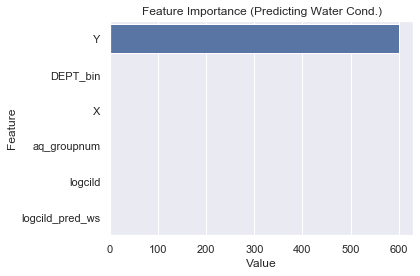

In [162]:
# #Plot 
# wellids = df2.Well.unique()

# for nam,y_test,y_predict in zip(wellids,y_tests,y_preds):
#     plt.scatter(y_test,y_predict,label=nam)
# plt.legend(loc=(1.05,.5))

c = np.concatenate( y_color, axis=0 )
# c = [welldict[nam] for nam in df_testing.Well]
cmap = cm.get_cmap('jet',len(np.unique(c)))

# bin_wiggle(y_predict,binsize=.1),
# y_pred = np.log10(1/np.power(10,(np.concatenate( y_preds, axis=0 ))))
# y_test = np.log10(1/np.power(10,(np.concatenate( y_tests, axis=0 ))))

# y_pred = np.log10(np.power(10,np.concatenate( y_preds, axis=0 ))/1e4)
# y_test=  np.log10(np.power(10,df_testing.logcondEC1f.values)/1e4)
y_pred = np.log10(np.power(10,np.concatenate( y_preds, axis=0 ))/1e4)
y_test= np.log10(df_testing.EC1f.values/1e4)



err_RF = y_pred-y_test
# y_test=  df_testing.logcondEC1f.values

f,ax = plt.subplots(1,figsize=(5,4))
plt.xlim(-1.5,1)
plt.ylim(-1.5,1)
ax.set_aspect('equal')
f,ax = x_y_regression(y_test,
                      y_pred,
#                         bin_wiggle(np.concatenate( y_tests, axis=0 )),
#                       np.concatenate( y_preds, axis=0 ),                      
#                         bin_wiggle(np.concatenate( y_tests, axis=0 )),
#                       bin_wiggle(np.concatenate( y_preds, axis=0 ),binsize=.1),
                      c,
                      ax=ax,
                      errtype='RMSE',
                      plotslp=False,slpname='slope',plotone2one=True,
                      edgecolors='k',linewidth=0,cmap=cmap)#,vmin=25,vmax=100);
plt.xlabel('Measured Water Cond. ($log_{10}$(S/m))')
plt.ylabel('Predicted Water Cond. ($log_{10}$(S/m))')
plt.title('Concatenated results from \nwell-by-well cross-validation')
plt.legend(loc='lower right')
cb = plt.colorbar()
cb.ax.set_ylabel('Well number')
ticks=  [num for nam,num in welldict.items() if (nam in allwells)]
ticklabels = [nam for nam,num in welldict.items() if (nam in allwells)]
# ticklabels = [nam for num,nam in enumerate(aq_names)]

cb.set_ticks(ticks)
cb.set_ticklabels(ticklabels)
# sns.kdeplot(np.concatenate( y_tests, axis=0 ),bin_wiggle(np.concatenate( y_preds, axis=0 ),binsize=.1),n_levels=20,shade=False,shade_lowest=False)
# # plt.axis('off')
plt.savefig(figdir.joinpath('RF_pred_logcondEC.png'),dpi=300,bbox_inches='tight')
plt.show()

# y_test = np.log10(df_testing.RILD.values)
# y_pred = df_testing.logrild_pred_ws.values

y_test = np.log10(df_testing.EC1f.values/1e4)
y_pred = np.log10(df_testing.Cw_pred_archie.values)
err_WS = y_pred-y_test

c = np.asarray([welldict[nam] for nam in df_testing.Well])


msk=~np.isnan(y_pred)
y_test = y_test[msk]
y_pred = y_pred[msk]
c = c[msk]
cmap = cm.get_cmap('jet',len(np.unique(c)))
f,ax = plt.subplots(1,figsize=(5,4))
plt.xlim(-1.5,1)
plt.ylim(-1.5,1)
ax.set_aspect('equal')
f,ax= x_y_regression(y_test,
                    y_pred,
                    c,
                    plotone2one=True,
                     ax=ax,plotslp=False,
                     errtype='RMSE',
                    slpname='slope',edgecolors='k',linewidth=0,cmap=cmap)#,vmin=25,vmax=100);
plt.xlabel('Measured Water Cond. ($log_{10}$(S/m))')
plt.ylabel('Predicted Water Cond. ($log_{10}$(S/m))')
plt.title('Waxman-Smits Prediction \nFormation Factor fitted from each Aquifer Group')
plt.legend(loc='lower right')
cb = plt.colorbar()
cb.ax.set_ylabel('Well number')
ticks=  [num for nam,num in welldict.items() if (nam in allwells)]
ticklabels = [nam for nam,num in welldict.items() if (nam in allwells)]
# ticklabels = [nam for num,nam in enumerate(aq_names)]
cb.set_ticks(ticks)
cb.set_ticklabels(ticklabels)
plt.legend(loc='lower right')

plt.savefig(figdir.joinpath('WS_pred_logcondEC.png'),dpi=300,bbox_inches='tight')
plt.show()

plt.figure()
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importances_,predictors)), columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature Importance (Predicting Water Cond.)')
plt.tight_layout()
plt.savefig(figdir.joinpath('FeatImportance_EC.png'),dpi=300,bbox_inches='tight')
print('RMSE_WS',rmse(y_test,y_pred))

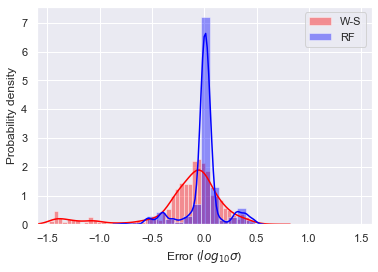

In [393]:
bins=np.linspace(-1.5,1,30)
# h,bins,patch = plt.hist(err,color='b',density=True,alpha=.5,label='RF',bins=bins)
# h,bins,patch = plt.hist((df_testing.logrild-df_testing.logrild_pred_ws),color='r',density=True,alpha=.5,label='W-S',bins=bins)
sns.distplot(np.log10(df_testing.EC1f.values/1e4)-np.log10(df_testing.Cw_pred_archie),color='red',kde=True,label='W-S')
sns.distplot(df_testing.err_pred_EC_RF,kde=True,color='blue',label='RF',bins=bins)
# err =  - np.log10(np.power(10,np.concatenate( y_preds, axis=0 ))/1e4)

plt.legend()
plt.xlabel('Error ($log_{10}\sigma$)')
plt.ylabel('Probability density')
plt.xlim(-1.6,1.6)
plt.savefig(figdir.joinpath('Err_logcond.png'),bbox_inches='tight',dpi=300)

### Predicting $log_{10} C_o$

In [74]:
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,GradientBoostingClassifier,RandomForestRegressor,AdaBoostClassifier,GradientBoostingRegressor
from sklearn.utils import resample
from sklearn.linear_model import BayesianRidge
from numpy.linalg import norm
df = update_FBS(df,'TDS1',breaks=np.arange(0,40000,3000))
df2 = update_df2()

np.random.seed(1)

n_repeat = 100# Number of iterations for computing expectations
max_depth = None
n_estimators = n_repeat
pcaobj = PCA
dopca=False

n_components = 5
max_features=None
####Choose the input data set#########
#Predict from water quality samples and lith
predicted = 'logcild_rem'
# predictors = ['logrild_pred_ws','logrhoEC_est'] <-- 27% RFregressor predicting logrild_spline, 3 comp, 2feat
# predictors = ['logcild_pred_ws','logcondEC_est','aq_groupnum','X','Y','C','M','G','S','DEPT'] #<-- 26% RFregressor predicting logcild_spline 3 comp, 2feat 
# predictors = ['logcild_pred_ws','logcondEC_est','X','Y','aq_groupnum','DEPT_bin']#<-- 24% RFregressor predicting logcild, 5 feat, no PCA
predictors = ['logcild_pred_ws','logcondEC_est','X','Y','aq_groupnum','DEPT_bin','FBS']#<-- 23% RFregressor predicting logcild, 5 feat, no PCA
predictors = ['TDS1','X','Y','aq_groupnum','Cb','Cb_a','Cb_b']#<-- 20.7% RFregressor predicting logcild, 5 feat, no PCA
predictors = ['TDS1','X','Y','aq_groupnum','DEPT_bin','lithnum_bin_conv','logcild_pred_ws']#<-- 20.7% RFregressor predicting logcild, 5 feat, no PCA

colorcolumn = 'aq_groupnum'

# class_list = [-16,-17,-18,-19]
# estimator=BaggingClassifier(DecisionTreeClassifier(
#     max_depth=max_depth),n_estimators=n_estimators,bootstrap_features=True)
# estimator = DecisionTreeRegressor(max_depth=max_depth,criterion='mae')
# estimator=GradientBoostingClassifier(n_estimators=n_estimators,max_depth=5,max_features=n_components)
# estimator=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth)
# estimator=BayesianRidge(n_iter=1000,tol=.0001)
# estimator = BaggingRegressor(DecisionTreeRegressor(max_depth=max_depth,criterion='mae'),n_estimators=n_estimators)
estimator=RandomForestRegressor(n_estimators=n_estimators,max_depth=max_depth,
                                min_samples_leaf=1,oob_score=False,max_features=max_features,criterion='mse',bootstrap=True)
# estimator=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,min_samples_leaf=1,max_features=max_features,class_weight='balanced')
# estimator = BayesianRidge(fit_intercept=True)
# estimator=GradientBoostingRegressor(loss='ls',n_estimators=n_estimators,max_depth=None,max_features=max_features)

y_preds = []
y_tests = []
y_color = []
errs = []
estimators = []
# df_testing= resample(df2,n_samples=10000)
df_testing = df2
# df_testing = df2.assign(samp=False)

df_testing = df_testing.assign(DEPT_bin = (np.round(df_testing.DEPT/100,0)*100).astype(np.int))
# df_testing = df_testing.assign(logrhoEC_est = np.log10(df_testing.loc[:,'Rw_est']))
df_testing = df_testing.assign(Region_bin = df_testing.loc[:,'Region']=='Marina')
df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logcondEC1f = np.log10(df_testing.loc[:,'EC1f']))

df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logcild_bin = np.round(np.log10(1/df_testing.RILD)*10,0))
df_testing = df_testing.assign(logcild_hmean_step = np.log10(1/np.power(10,df_testing.logrild_hmean_step)))

df_testing = df_testing.assign(logcild_hmean_bin =np.round(np.log10(1/np.power(10,df_testing.logrild_hmean_step))*10,0))
df_testing = df_testing.assign(logrild_hmean_bin =np.round(df_testing.logrild_hmean_step*10,0))

df_testing = df_testing.assign(logcild_spline_bin = np.round(df_testing.logcild_spline*10,0))
df_testing = df_testing.assign(logcild = np.log10(1/df_testing.RILD))
df_testing = df_testing.assign(logcild_pred_ws = np.log10(1/np.power(10,df_testing.logrild_pred_ws)))
df_testing = df_testing.assign(logcild_pred_archie = np.log10(1/np.power(10,df_testing.logrild_pred_archie)))
df_testing = df_testing.assign(logcild_rem = df_testing.logcild - df_testing.logcild_pred_archie)

df_testing = df_testing.assign(err_ws = np.abs(np.log10(1/df_testing.RILD) - df_testing.logcild_pred_ws))

df_testing = df_testing.assign(cild_bin = np.round(1/df2.RILD*10,0))
df_testing = df_testing.assign(cond_est = 1/tds2rho_est(df2.TDS1))
df_testing = df_testing.assign(cond_est_bin = np.round( (df_testing.cond_est /1).astype(np.float),0)*1)
df_testing = df_testing.assign(logcond_est = np.log10((df_testing.cond_est).astype(np.float) ))
df_testing = df_testing.assign(logrhoEC_est = np.log10(tds2rho_est(df_testing.TDS1).astype(np.float)))
df_testing = df_testing.assign(logcondEC_est = np.log10(1/(tds2rho_est(df_testing.TDS1).astype(np.float))))

df_testing = df_testing.assign(logrild_conv_bin = (np.round(df_testing.logrild_conv,1)*10).values.astype(int))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))

list_of_conditions = (df2.RILD.notnull(),
                      df2.FBS.notnull(),
                      df2.lith.notnull(),
                      df2.Y.notnull(),
                      df2.Region=='Marina')
conditions = [df_testing.loc[:,predictor].notnull() for predictor in predictors]
df_testing = df_testing.loc[nested_logicals(df_testing,list_of_conditions,func=np.logical_and)]
# df_testing = df_testing.loc[df_testing.lithnum_bin_conv==1,:]

# # # ##### Standardize, PCA
if dopca:
    data = df_testing.loc[:,predictors]
    df_testing,predictors = standardize_pca(data,pcaobj=pcaobj, n_components=n_components,df_concat=df_testing)
# df_testing,predictors = standardize(data,colnames=predictors,df_concat=df_testing)


# ###### Add in all lith descriptors
# df_testing = df_testing.sort_values(by='lith')
# ohc = df_testing.loc[:,['lith']]
# ohc =  pd.get_dummies(ohc,drop_first=False)
# predictors = np.concatenate((predictors,ohc.columns.values))
# df_testing = pd.concat((df_testing,ohc),axis=1)

# #######################
allwells = df_testing.Well.unique()

print('Wells with available data:',allwells)
for nam in allwells:
    testwell = nam
    trainwells = [wellid for wellid in allwells if wellid!=testwell]

    df_train = df_testing.loc[df_testing.Well.isin(trainwells)]
#     df_test = df_testing.loc[np.logical_and(df_testing.Well==testwell,df_testing.samp==False)]
    df_test = df_testing.loc[df_testing.Well==testwell]
    X_train = df_train.loc[:,predictors]
    y_train = df_train.loc[:,predicted]

    X_test = df_test.loc[:,predictors]
    y_test = df_test.loc[:,predicted]
#     estimator.class_weight = make_class_weight(y_train,class_list)
    estimator.fit(X_train,y_train)
    y_predict = estimator.predict(X_test)
    y_train_predict = estimator.predict(X_train)

#     y_train = y_train/10
#     y_predict = y_predict/10
#     y_train_predict = y_train_predict/10
#     y_test = y_test/10
#     err_down,err_up = pred_ints(estimator, X_test, percentile=95)

    y_tests.append(y_test.values)
    y_preds.append(y_predict)
    y_color.append([welldict[nam] for nam in df_test.Well])
#     errs.append(np.vstack((err_down,err_up)))
    estimators.append(estimator)
    print('testing on',nam,
          '\tno. samples:',len(X_train),
          '\ttest size:',len(X_test),
          '\tNormErr:',100*np.round(norm(y_test-y_predict)/norm(y_test),1),'%')

    
# y_pred_RF = np.log10(1/np.power(10,(np.concatenate( y_preds, axis=0 ))))
# y_test = np.log10(1/np.power(10,(np.concatenate( y_tests, axis=0 ))))


y_pred_RF = np.concatenate( y_preds, axis=0 )
y_test= np.concatenate( y_tests, axis=0 )


err = (y_test-y_pred_RF)
df_testing = df_testing.assign(err_pred_RF=err)
print("Norm Err:",np.round(100*np.linalg.norm(err/np.linalg.norm(y_test)),2),'%')
print("RMSE:",rmse(df_testing.logcild,y_pred_RF + df_testing.logcild_pred_archie) )

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in log10


Wells with available data: ['CX-B1' 'CX-B2' 'CX-B4' 'MDW-1' 'ML-1' 'ML-2' 'ML-3' 'ML-4' 'ML-6'
 'MW-1D' 'MW-4D' 'MW-5D' 'MW-6D' 'MW-7D' 'MW-8D' 'MW-9D' 'PR-1']
testing on CX-B1 	no. samples: 2932 	test size: 120 	NormErr: 70.0 %
testing on CX-B2 	no. samples: 2972 	test size: 80 	NormErr: 120.0 %
testing on CX-B4 	no. samples: 2952 	test size: 100 	NormErr: 90.0 %
testing on MDW-1 	no. samples: 2972 	test size: 80 	NormErr: 100.0 %
testing on ML-1 	no. samples: 3022 	test size: 30 	NormErr: 170.0 %
testing on ML-2 	no. samples: 3012 	test size: 40 	NormErr: 80.0 %
testing on ML-3 	no. samples: 3012 	test size: 40 	NormErr: 70.0 %
testing on ML-4 	no. samples: 3012 	test size: 40 	NormErr: 130.0 %
testing on ML-6 	no. samples: 3012 	test size: 40 	NormErr: 130.0 %
testing on MW-1D 	no. samples: 2745 	test size: 307 	NormErr: 90.0 %
testing on MW-4D 	no. samples: 2651 	test size: 401 	NormErr: 90.0 %
testing on MW-5D 	no. samples: 2552 	test size: 500 	NormErr: 90.0 %
testing on MW-6D 	n

In [70]:
rmse(df_testing.logcild,y_pred_RF + df_testing.logcild_pred_archie)

0.5758042641068888

In [104]:
##Assign the prediction and mean predicted value to df
df_testing = df_testing.assign(logcild_pred_RF=y_pred_RF)
mean_est= np.zeros(len(df_testing))
ind1=0
for nam in df_testing.Well.unique():
    ind= np.arange(ind1,ind1+len(df_testing.loc[df_testing.Well==nam]))
    mean_est[ind] = df_testing.loc[df_testing.Well==nam,'logcild_pred_RF'].mean()
    ind1=ind[-1]+1
df_testing = df_testing.assign(logcild_mean_est=mean_est)


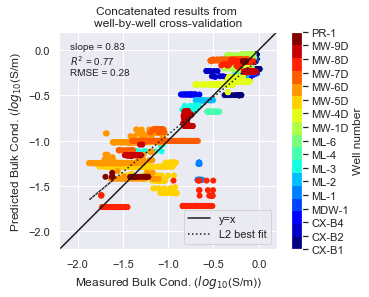

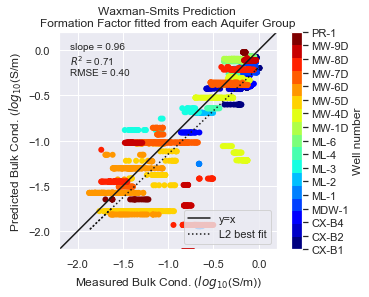

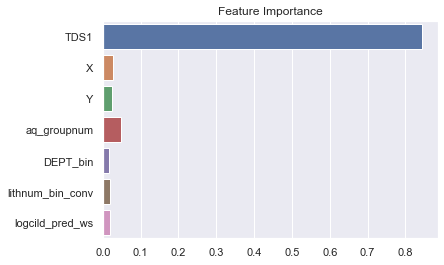

In [75]:
# #Plot 
# wellids = df2.Well.unique()

# for nam,y_test,y_predict in zip(wellids,y_tests,y_preds):
#     plt.scatter(y_test,y_predict,label=nam)
# plt.legend(loc=(1.05,.5))

c = np.concatenate( y_color, axis=0 )
# c = [welldict[nam] for nam in df_testing.Well]
cmap = cm.get_cmap('jet',len(np.unique(c)))

# bin_wiggle(y_predict,binsize=.1),
# y_pred = np.log10(1/np.power(10,(np.concatenate( y_preds, axis=0 ))))
# y_test = df_testing.logcild

# y_pred = np.log10(1/np.power(10,np.concatenate( y_preds, axis=0 )))
# y_test=  np.log10(1/np.power(10,df_testing.logcondEC1f.values))

y_pred = y_pred_RF + df_testing.logcild_pred_archie
y_test= df_testing.logcild

f,ax = plt.subplots(1,figsize=(5,4))
plt.xlim(-2.2,.2)
plt.ylim(-2.2,.2)
ax.set_aspect('equal')
f,ax = x_y_regression(y_test,
                      y_pred,
#                         bin_wiggle(np.concatenate( y_tests, axis=0 )),
#                       np.concatenate( y_preds, axis=0 ),                      
#                         bin_wiggle(np.concatenate( y_tests, axis=0 )),
#                       bin_wiggle(np.concatenate( y_preds, axis=0 ),binsize=.1),
                      c,
                      ax=ax,errtype="RMSE",
                      plotslp=True,slpname='slope',plotone2one=True,
                      edgecolors='k',linewidth=0,cmap=cmap)
plt.xlabel('Measured Bulk Cond. ($log_{10}$(S/m))')
plt.ylabel('Predicted Bulk Cond. ($log_{10}$(S/m)')
plt.title('Concatenated results from \nwell-by-well cross-validation')
plt.legend(loc='lower right')
cb = plt.colorbar()
cb.ax.set_ylabel('Well number')
ticks=  [num for nam,num in welldict.items() if (nam in allwells)]
ticklabels = [nam for nam,num in welldict.items() if (nam in allwells)]
# ticklabels = [nam for num,nam in enumerate(aq_names)]

cb.set_ticks(ticks)
cb.set_ticklabels(ticklabels)
# sns.kdeplot(np.concatenate( y_tests, axis=0 ),bin_wiggle(np.concatenate( y_preds, axis=0 ),binsize=.1),n_levels=20,shade=False,shade_lowest=False)
# # plt.axis('off')
# plt.xlim([-1.25,2])
# plt.ylim([-1.25,2])
plt.savefig(figdir.joinpath('RF_pred_logcild_MPWSP.png'),dpi=300,bbox_inches='tight')
plt.show()


# y_test = np.log10(df_testing.RILD.values)
# y_pred = df_testing.logrild_pred_ws.values
y_test    = df_testing.logcild
y_pred = np.log10(1/np.power(10,df_testing.logrild_pred_ws))

c = np.asarray([welldict[nam] for nam in df_testing.Well])


msk=~np.isnan(y_pred)
y_test = y_test[msk]
y_pred = y_pred[msk]
c = c[msk]
cmap = cm.get_cmap('jet',len(np.unique(c)))
f,ax = plt.subplots(1,figsize=(5,4))
plt.xlim(-2.2,.2)
plt.ylim(-2.2,.2)
ax.set_aspect('equal')

f,ax= x_y_regression(y_test,
                    y_pred,
                    c,
                    plotone2one=True,
                     ax=ax,errtype='RMSE',
                    slpname='slope',edgecolors='k',linewidth=0,cmap=cmap)#,vmin=25,vmax=100);
# sns.kdeplot(y_test,y_pred,n_levels=20,shade=False,shade_lowest=False)

plt.xlabel('Measured Bulk Cond. ($log_{10}$(S/m))')
plt.ylabel('Predicted Bulk Cond. ($log_{10}$(S/m)')
plt.title('Waxman-Smits Prediction \nFormation Factor fitted from each Aquifer Group')
plt.legend(loc='lower right')
cb = plt.colorbar()
cb.ax.set_ylabel('Well number')
ticks=  [num for nam,num in welldict.items() if (nam in allwells)]
ticklabels = [nam for nam,num in welldict.items() if (nam in allwells)]
# ticklabels = [nam for num,nam in enumerate(aq_names)]
cb.set_ticks(ticks)
cb.set_ticklabels(ticklabels)
plt.legend(loc='lower right')

plt.savefig(figdir.joinpath('WS_pred_logcild_MPWSP.png'),dpi=300,bbox_inches='tight')
plt.show()

plt.figure()
scores = 0
for i in range(len(estimator.estimators_)):
    scores += np.asarray(estimator.estimators_).flatten()[i].feature_importances_
scores /= n_repeat
sns.barplot(x=scores,y=X_test.columns)
plt.title('Feature Importance');
# plt.savefig(figdir.joinpath('FeatureImportance.png'),bbox_inches='tight',dpi=300)
# export_tree(figdir,estimator.estimators_[0],max_depth=5,predictors=predictors,prefix='Tree_')

(-1.6, 1.6)

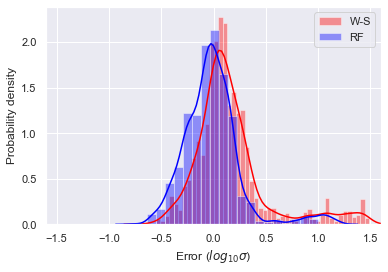

In [76]:
bins=np.linspace(-1.5,1,30)
# h,bins,patch = plt.hist(err,color='b',density=True,alpha=.5,label='RF',bins=bins)
# h,bins,patch = plt.hist((df_testing.logrild-df_testing.logrild_pred_ws),color='r',density=True,alpha=.5,label='W-S',bins=bins)
sns.distplot((df_testing.logcild-df_testing.logcild_pred_ws),color='red',kde=True,label='W-S')
sns.distplot(df_testing.err_pred_RF,kde=True,color='blue',label='RF',bins=bins)

plt.legend()
plt.xlabel('Error ($log_{10}\sigma$)')
plt.ylabel('Probability density')
plt.xlim(-1.6,1.6)
# plt.savefig(figdir.joinpath('Err_logcild.png'),bbox_inches='tight',dpi=300)


### Predicting water conductivity

In [408]:
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,GradientBoostingClassifier,RandomForestRegressor,AdaBoostClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import BayesianRidge,RANSACRegressor
from sklearn.utils import resample
from numpy.linalg import norm
df = update_FBS(df,'TDS1',breaks=np.arange(0,40000,3000))
df2 = update_df2()

np.random.seed(1)

n_repeat = 100# Number of iterations for computing expectations
max_depth = None
n_estimators = n_repeat
pcaobj = PCA
dopca=False

n_components = 4
max_features=5
####Choose the input data set#########
#Predict from water quality samples and lith
predicted = 'logcondEC1f'
# predictors = ['logrild_pred_ws','logrhoEC_est'] <-- 27% RFregressor predicting logrild_spline, 3 comp, 2feat
# predictors = ['logcild_pred_ws','logcondEC_est','aq_groupnum','X','Y','C','M','G','S','DEPT'] #<-- 26% RFregressor predicting logcild_spline 3 comp, 2feat 
# predictors = ['logcild_pred_ws','logcondEC_est','X','Y','aq_groupnum','DEPT_bin']#<-- 24% RFregressor predicting logcild, 5 feat, no PCA
predictors = ['logcild_pred_ws','logcondEC_est','X','Y','aq_groupnum','DEPT_bin','FBS']#<-- 23% RFregressor predicting logcild, 5 feat, no PCA
predictors = ['logcild_pred_ws','logcild','X','Y','aq_groupnum','DEPT_bin']#<-- 23% RFregressor predicting logcild, 5 feat, no PCA

colorcolumn = 'aq_groupnum'

# class_list = [-16,-17,-18,-19]

# estimator=BaggingClassifier(DecisionTreeClassifier(
#     max_depth=max_depth),n_estimators=n_estimators,bootstrap_features=True)
# estimator = DecisionTreeRegressor(max_depth=max_depth,criterion='mae')
# estimator=GradientBoostingClassifier(n_estimators=n_estimators,max_depth=5,max_features=n_components)
# estimator=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth)
# estimator=BayesianRidge(n_iter=1000,tol=.0001)
# estimator = BaggingRegressor(DecisionTreeRegressor(max_depth=max_depth,criterion='mae'),n_estimators=n_estimators)
estimator=RandomForestRegressor(n_estimators=n_estimators,max_depth=max_depth,
                                min_samples_leaf=1,oob_score=False,max_features=max_features,criterion='mse',bootstrap=True)
# estimator=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,min_samples_leaf=1,max_features=max_features,class_weight='balanced')
# estimator = BayesianRidge()
# estimator = RANSACRegressor()
y_preds = []
y_tests = []
y_color = []
errs = []
estimators = []
# df_testing= resample(df2,n_samples=10000)
df_testing = df2
# df_testing = df2.assign(samp=False)

df_testing = df_testing.assign(DEPT_bin = (np.round(df_testing.DEPT/100,0)*100).astype(np.int))
# df_testing = df_testing.assign(logrhoEC_est = np.log10(df_testing.loc[:,'Rw_est']))
df_testing = df_testing.assign(Region_bin = df_testing.loc[:,'Region']=='Marina')
df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logcondEC1f = np.log10(df_testing.loc[:,'EC1f']))

df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logcild_bin = np.round(np.log10(1/df_testing.RILD)*10,0))
df_testing = df_testing.assign(logcild_spline_bin = np.round(df_testing.logcild_spline*10,0))
df_testing = df_testing.assign(logcild = np.log10(1/df_testing.RILD))
df_testing = df_testing.assign(logcild_pred_ws = np.log10(1/np.power(10,df_testing.logrild_pred_ws)))
df_testing = df_testing.assign(err_ws = np.abs(np.log10(1/df_testing.RILD) - df_testing.logcild_pred_ws))

df_testing = df_testing.assign(cild_bin = np.round(1/df2.RILD*10,0))
df_testing = df_testing.assign(cond_est = 1/tds2rho_est(df2.TDS1))
df_testing = df_testing.assign(cond_est_bin = np.round( (df_testing.cond_est /1).astype(np.float),0)*1)
df_testing = df_testing.assign(logcond_est = np.log10((df_testing.cond_est).astype(np.float) ))
df_testing = df_testing.assign(logrhoEC_est = np.log10(tds2rho_est(df_testing.TDS1).astype(np.float)))
df_testing = df_testing.assign(logcondEC_est = np.log10(1/(tds2rho_est(df_testing.TDS1).astype(np.float))))

df_testing = df_testing.assign(logrild_conv_bin = (np.round(df_testing.logrild_conv,1)*10).values.astype(int))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))

list_of_conditions = (df2.RILD.notnull(),
                      df2.FBS.notnull(),
                      df2.lith.notnull(),
                      df2.Y.notnull(),
                      df2.Region=='Marina')

conditions = [df_testing.loc[:,predictor].notnull() for predictor in predictors]
df_testing = df_testing.loc[nested_logicals(df_testing,list_of_conditions,func=np.logical_and)]
# df_testing = df_testing.loc[df_testing.lithnum_bin_conv==1,:]

# # # ##### Standardize, PCA
if dopca:
    data = df_testing.loc[:,predictors]
    df_testing,predictors = standardize_pca(data,pcaobj=pcaobj, n_components=n_components,df_concat=df_testing)
# df_testing,predictors = standardize(data,colnames=predictors,df_concat=df_testing)


# ###### Add in all lith descriptors
# df_testing = df_testing.sort_values(by='lith')
# ohc = df_testing.loc[:,['lith']]
# ohc =  pd.get_dummies(ohc,drop_first=False)
# predictors = np.concatenate((predictors,ohc.columns.values))
# df_testing = pd.concat((df_testing,ohc),axis=1)

# #######################
allwells = df_testing.Well.unique()

print('Wells with available data:',allwells)
for nam in allwells:
    testwell = nam
    trainwells = [wellid for wellid in allwells if wellid!=testwell]

    df_train = df_testing.loc[df_testing.Well.isin(trainwells)]
#     df_test = df_testing.loc[np.logical_and(df_testing.Well==testwell,df_testing.samp==False)]
    df_test = df_testing.loc[df_testing.Well==testwell]
    X_train = df_train.loc[:,predictors]
    y_train = df_train.loc[:,predicted]

    X_test = df_test.loc[:,predictors]
    y_test = df_test.loc[:,predicted]
#     estimator.class_weight = make_class_weight(y_train,class_list)
    estimator.fit(X_train,y_train)
    y_predict = estimator.predict(X_test)
    y_train_predict = estimator.predict(X_train)

#     y_train = y_train/10
#     y_predict = y_predict/10
#     y_train_predict = y_train_predict/10
#     y_test = y_test/10
#     err_down,err_up = pred_ints(estimator, X_test, percentile=95)

    y_tests.append(y_test.values)
    y_preds.append(y_predict)
    y_color.append([welldict[nam] for nam in df_test.Well])
#     errs.append(np.vstack((err_down,err_up)))
    estimators.append(estimator)
    print('testing on',nam,
          '\tno. samples:',len(X_train),
          '\ttest size:',len(X_test),
          '\tNormErr:',np.round(100*norm(y_test-y_predict)/norm(y_test),1),'%')

    
# y_pred_RF = np.log10(1/np.power(10,(np.concatenate( y_preds, axis=0 ))))
# y_test = np.log10(1/np.power(10,(np.concatenate( y_tests, axis=0 ))))


y_pred_Cw_RF = np.concatenate( y_preds, axis=0 )
y_test= np.concatenate( y_tests, axis=0 )


err = (y_test-y_pred_Cw_RF)

print("Norm Err:",np.round(100*np.linalg.norm(err/np.linalg.norm(y_test)),2),'%')

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in log10


Wells with available data: ['CX-B1' 'CX-B2' 'CX-B4' 'MDW-1' 'ML-1' 'ML-2' 'ML-3' 'ML-4' 'ML-6'
 'MW-1D' 'MW-4D' 'MW-5D' 'MW-6D' 'MW-7D' 'MW-8D' 'MW-9D' 'PR-1']
testing on CX-B1 	no. samples: 3001 	test size: 120 	NormErr: 1.1 %
testing on CX-B2 	no. samples: 3041 	test size: 80 	NormErr: 1.5 %
testing on CX-B4 	no. samples: 3021 	test size: 100 	NormErr: 9.7 %
testing on MDW-1 	no. samples: 3041 	test size: 80 	NormErr: 0.5 %
testing on ML-1 	no. samples: 3091 	test size: 30 	NormErr: 23.6 %
testing on ML-2 	no. samples: 3081 	test size: 40 	NormErr: 0.9 %
testing on ML-3 	no. samples: 3081 	test size: 40 	NormErr: 13.2 %
testing on ML-4 	no. samples: 3081 	test size: 40 	NormErr: 1.0 %
testing on ML-6 	no. samples: 3081 	test size: 40 	NormErr: 0.7 %
testing on MW-1D 	no. samples: 2801 	test size: 320 	NormErr: 7.6 %
testing on MW-4D 	no. samples: 2705 	test size: 416 	NormErr: 8.3 %
testing on MW-5D 	no. samples: 2621 	test size: 500 	NormErr: 7.0 %
testing on MW-6D 	no. samples: 282

#### Co = (Cw + BxQv) x (1/F)


In [353]:
df_testing = df_testing.assign(logcondCw_pred_RF=y_pred_Cw_RF)

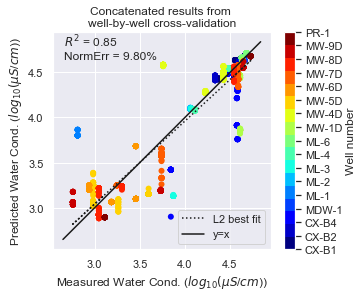

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in log10


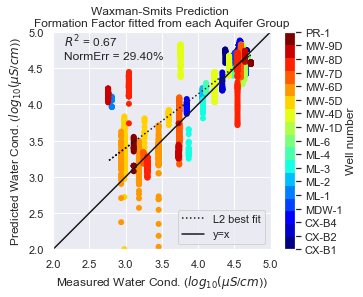

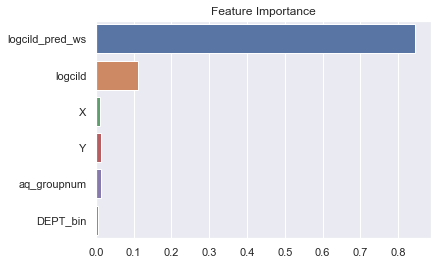

In [418]:
# #Plot 
# wellids = df2.Well.unique()

# for nam,y_test,y_predict in zip(wellids,y_tests,y_preds):
#     plt.scatter(y_test,y_predict,label=nam)
# plt.legend(loc=(1.05,.5))

c = np.concatenate( y_color, axis=0 )
# c = [welldict[nam] for nam in df_testing.Well]
cmap = cm.get_cmap('jet',len(np.unique(c)))

# bin_wiggle(y_predict,binsize=.1),
# y_pred = np.log10(1/np.power(10,(np.concatenate( y_preds, axis=0 ))))
# y_test = np.log10(1/np.power(10,(np.concatenate( y_tests, axis=0 ))))

# y_pred = np.log10(np.power(10,np.concatenate( y_preds, axis=0 ))/1e4)
# y_test=  np.log10(np.power(10,df_testing.logcondEC1f.values)/1e4)
y_pred = np.concatenate( y_preds, axis=0 )
y_test= df_testing.logcondEC1f.values



err_RF = y_pred-y_test
# y_test=  df_testing.logcondEC1f.values

f,ax = plt.subplots(1,figsize=(5,4))
# plt.xlim(2,5)
# plt.ylim(2,5)
ax.set_aspect('equal')
f,ax = x_y_regression(y_test,
                      y_pred,
#                         bin_wiggle(np.concatenate( y_tests, axis=0 )),
#                       np.concatenate( y_preds, axis=0 ),                      
#                         bin_wiggle(np.concatenate( y_tests, axis=0 )),
#                       bin_wiggle(np.concatenate( y_preds, axis=0 ),binsize=.1),
                      c,
                      ax=ax,
                      plotslp=False,slpname='slope',plotone2one=True,
                      edgecolors='k',linewidth=0,cmap=cmap)#,vmin=25,vmax=100);
plt.xlabel('Measured Water Cond. ($log_{10}(\mu S$/$cm$))')
plt.ylabel('Predicted Water Cond. ($log_{10}(\mu S$/$cm$))')
plt.title('Concatenated results from \nwell-by-well cross-validation')
plt.legend(loc='lower right')
cb = plt.colorbar()
cb.ax.set_ylabel('Well number')
ticks=  [num for nam,num in welldict.items() if (nam in allwells)]
ticklabels = [nam for nam,num in welldict.items() if (nam in allwells)]
# ticklabels = [nam for num,nam in enumerate(aq_names)]

cb.set_ticks(ticks)
cb.set_ticklabels(ticklabels)
# sns.kdeplot(np.concatenate( y_tests, axis=0 ),bin_wiggle(np.concatenate( y_preds, axis=0 ),binsize=.1),n_levels=20,shade=False,shade_lowest=False)
# # plt.axis('off')
# plt.xlim([-1.25,2])
# plt.ylim([-1.25,2])
plt.savefig(figdir.joinpath('RF_pred_logcondEC.png'),dpi=300,bbox_inches='tight')
plt.show()


# y_test = np.log10(df_testing.RILD.values)
# y_pred = df_testing.logrild_pred_ws.values

y_test = df_testing.logcondEC1f.values
y_pred = np.log10(df_testing.Cw_pred_ws.values*1e4)
err_WS = y_pred-y_test

c = np.asarray([welldict[nam] for nam in df_testing.Well])


msk=~np.isnan(y_pred)
y_test = y_test[msk]
y_pred = y_pred[msk]
c = c[msk]
cmap = cm.get_cmap('jet',len(np.unique(c)))
f,ax = plt.subplots(1,figsize=(5,4))
plt.xlim(2,5)
plt.ylim(2,5)
ax.set_aspect('equal')

f,ax= x_y_regression(y_test,
                    y_pred,
                    c,
                    plotone2one=True,
                     ax=ax,plotslp=False,
                    slpname='slope',edgecolors='k',linewidth=0,cmap=cmap)#,vmin=25,vmax=100);
plt.xlabel('Measured Water Cond. ($log_{10}(\mu S$/$cm$))')
plt.ylabel('Predicted Water Cond. ($log_{10}(\mu S$/$cm$))')
plt.title('Waxman-Smits Prediction \nFormation Factor fitted from each Aquifer Group')
plt.legend(loc='lower right')
cb = plt.colorbar()
cb.ax.set_ylabel('Well number')
ticks=  [num for nam,num in welldict.items() if (nam in allwells)]
ticklabels = [nam for nam,num in welldict.items() if (nam in allwells)]
# ticklabels = [nam for num,nam in enumerate(aq_names)]
cb.set_ticks(ticks)
cb.set_ticklabels(ticklabels)
plt.legend(loc='lower right')
# plt.xlim([-1.25,2])
# plt.ylim([-1.25,2])

plt.savefig(figdir.joinpath('WS_pred_logcondEC.png'),dpi=300,bbox_inches='tight')
plt.show()

plt.figure()
scores = 0
for i in range(len(estimator.estimators_)):
    scores += np.asarray(estimator.estimators_).flatten()[i].feature_importances_
scores /= n_repeat
sns.barplot(x=scores,y=X_test.columns)
plt.title('Feature Importance');
# plt.savefig(figdir.joinpath('FeatureImportance.png'),bbox_inches='tight',dpi=300)
# export_tree(figdir,estimator.estimators_[0],max_depth=5,predictors=predictors,prefix='Tree_')

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


(-1.6, 1.6)

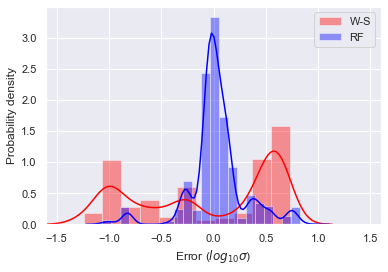

In [424]:
bins=np.linspace(-1.5,1,30)
# h,bins,patch = plt.hist(err,color='b',density=True,alpha=.5,label='RF',bins=bins)
# h,bins,patch = plt.hist((df_testing.logrild-df_testing.logrild_pred_ws),color='r',density=True,alpha=.5,label='W-S',bins=bins)
ax=sns.distplot((df_testing.logcondEC1f -  np.log10(df_testing.Cw_pred_ws.notnull()*1e4)),color='red',kde=True,label='W-S')
sns.distplot(df_testing.logcondEC1f - y_pred_Cw_RF,kde=True,color='blue',label='RF',bins=bins)


y_test = df_testing.logcondEC1f.values
y_pred = np.log10(df_testing.Cw_pred_ws.values*1e4)

plt.legend()
plt.xlabel('Error ($log_{10}\sigma$)')
plt.ylabel('Probability density')
plt.xlim(-1.6,1.6)
# plt.savefig(figdir.joinpath('Err_logcild.png'),bbox_inches='tight',dpi=300)


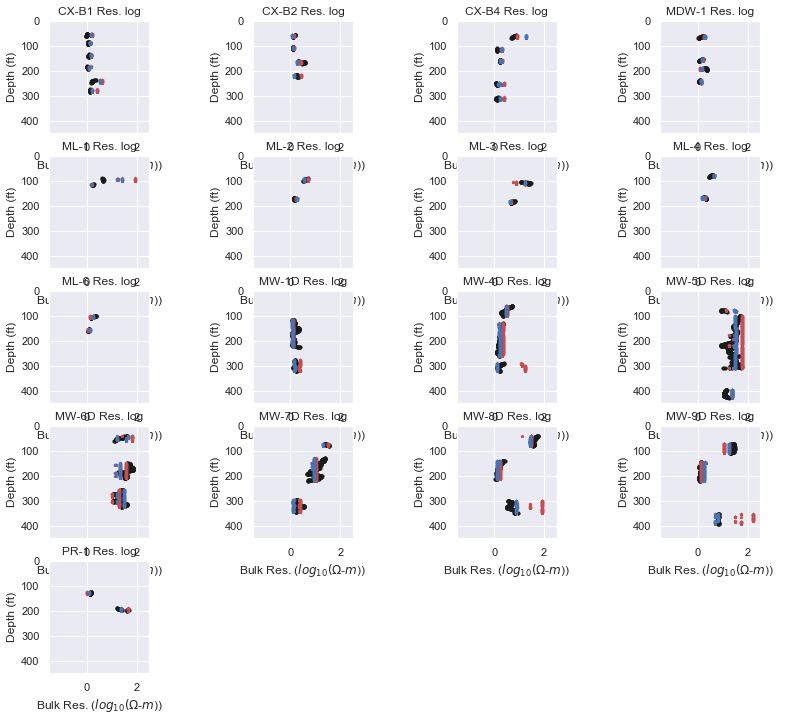

In [410]:
df_plot = df_testing
s=5
f,axs=plt.subplots(5,4,figsize=(14,12))
plt.set_cmap('jet')
cmap = cm.get_cmap('viridis',len(df.lithnum_bin.unique()))  

for i,nam in enumerate(df_testing.Well.unique()):
    plt.sca(axs.flatten()[i])
    ax = plt.gca()
    if i == axs.size-1:
        plt.axis('off')
        continue
    ax.set_xlim([-1.5,2.5])
#     ax.set_xlim([-.5,5])
    ax.set_ylim([0,450])
    ax.invert_yaxis()
    d=df_plot.loc[df_plot.Well==nam,'DEPT']
    s1=plt.scatter(df_plot.loc[df_plot.Well==nam,'logrild'],d,
                   s=10, label='Bulk Res.',
#                    c=np.abs(df_plot.loc[df_plot.Well==nam,'err_pred_RF']),
                   c='k',
                   vmin=0,vmax=.3)
    
    s3=plt.scatter(df_plot.loc[df_plot.Well==nam,'logrild_pred_ws'],d,
                   s=7, label='Bulk Res.',marker='*',
                   c='r')
    s2=plt.scatter(df_plot.loc[df_plot.Well==nam,'logrild_pred_RF'],d,
                   s=7, label='Bulk Res.',marker='*',
                   c='b')
#     s3=plt.scatter(np.log10(df_plot.loc[df_plot.Well==nam,'Cw_pred_ws']*1e4),d,
#                    s=3, label='Bulk Res.',marker='*',
#                    c='r')

#     s3=plt.scatter(df_plot.loc[df_plot.Well==nam,'logcondCw_pred_RF'],d,
#                    s=3, label='Bulk Res.',marker='*',
#                    c='b')
#     s3=plt.scatter(np.log10(df_plot.loc[df_plot.Well==nam,'EC1f']),d,
#                    s=3, label='Bulk Res.',marker='*',
#                    c='k')

        
    plt.ylabel('Depth (ft)')
    plt.xlabel('Bulk Res. ($log_{10}(\Omega$-$m$))');
    ax.set_aspect(1/100)
    plt.title(nam + ' Res. log');

for i,ax in enumerate(axs.flatten()):
    if i >= len(df_testing.Well.unique()):
        plt.sca(ax)
        plt.axis('off')
# plt.savefig(figdir.joinpath('ErrLog_WS_RF.png'),dpi=500,bbox_inches='tight')

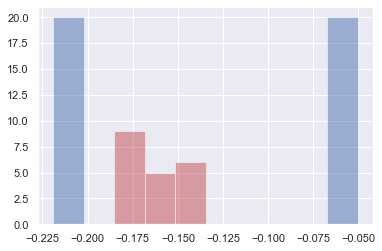

In [260]:
err_RF = df_plot.loc[df_plot.Well==nam,'logcondCw_pred_RF'] - np.log10(df_plot.loc[df_plot.Well==nam,'EC1f'])
err_WS = np.log10(df_plot.loc[df_plot.Well==nam,'Cw_pred_ws']*1e4) - np.log10(df_plot.loc[df_plot.Well==nam,'EC1f'])

h,bins,patch= plt.hist(err_RF,color='b',alpha=.5,)
h,bins,patch = plt.hist(err_WS,color='r',bins=bins,alpha=.5)
# sns.distplot(err_RF,kde=True,color='blue')
# sns.distplot(err_WS[~np.isnan(err_WS)],color='red',kde=True)

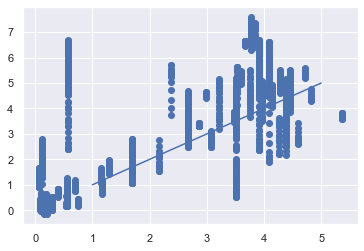

In [628]:
plt.scatter(df_testing.EC1f/1e4,df_testing.Cw_pred_ws)
plt.plot((1,5),(1,5))

Text(0, 0.5, 'err')

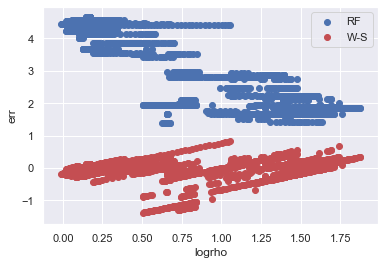

In [247]:
plt.scatter(df_testing.logrild,err,c='b',label='RF')
plt.scatter(df_testing.logrild,(df_testing.logrild-df_testing.logrild_pred_ws),c='r',label='W-S')
plt.legend()
plt.xlabel('logrho')
plt.ylabel('err')

### Predicting $log_{10} C_o$ without W-S

In [401]:
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,GradientBoostingClassifier,RandomForestRegressor,AdaBoostClassifier
from sklearn.utils import resample
from numpy.linalg import norm
df = update_FBS(df,'TDS1',breaks=np.arange(0,40000,3000))
df2 = update_df2()

np.random.seed(1)

n_repeat = 100# Number of iterations for computing expectations
max_depth = None
n_estimators = n_repeat
pcaobj = PCA
dopca=False

n_components = 4
max_features=1
####Choose the input data set#########
#Predict from water quality samples and lith
predicted = 'logcild'
# predictors = ['logrild_pred_ws','logrhoEC_est'] <-- 27% RFregressor predicting logrild_spline, 3 comp, 2feat
# predictors = ['logcild_pred_ws','logcondEC_est','aq_groupnum','X','Y','C','M','G','S','DEPT'] #<-- 26% RFregressor predicting logcild_spline 3 comp, 2feat 
# predictors = ['logcild_pred_ws','logcondEC_est','X','Y','aq_groupnum','DEPT_bin']#<-- 24% RFregressor predicting logcild, 5 feat, no PCA
predictors = ['logcondEC_est','X','Y','']#<-- 23% RFregressor predicting logcild, 5 feat, no PCA

colorcolumn = 'aq_groupnum'

# class_list = [-16,-17,-18,-19]
# estimator=BaggingClassifier(DecisionTreeClassifier(
#     max_depth=max_depth),n_estimators=n_estimators,bootstrap_features=True)
# estimator = DecisionTreeRegressor(max_depth=max_depth,criterion='mae')
# estimator=GradientBoostingClassifier(n_estimators=n_estimators,max_depth=5,max_features=n_components)
# estimator=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth)
# estimator=BayesianRidge(n_iter=1000,tol=.0001)
# estimator = BaggingRegressor(DecisionTreeRegressor(max_depth=max_depth,criterion='mae'),n_estimators=n_estimators)
estimator=RandomForestRegressor(n_estimators=n_estimators,max_depth=max_depth,
                                min_samples_leaf=1,oob_score=False,max_features=max_features,criterion='mse',bootstrap=True)
# estimator=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,min_samples_leaf=1,max_features=max_features,class_weight='balanced')
# estimator = BayesianRidge(fit_intercept=True)
y_preds = []
y_tests = []
y_color = []
errs = []
estimators = []
# df_testing= resample(df2,n_samples=10000)
df_testing = df2
# df_testing = df2.assign(samp=False)

df_testing = df_testing.assign(DEPT_bin = (np.round(df_testing.DEPT/100,0)*100).astype(np.int))
# df_testing = df_testing.assign(logrhoEC_est = np.log10(df_testing.loc[:,'Rw_est']))
df_testing = df_testing.assign(Region_bin = df_testing.loc[:,'Region']=='Marina')
df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logcondEC1f = np.log10(df_testing.loc[:,'EC1f']))

df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logcild_bin = np.round(np.log10(1/df_testing.RILD)*10,0))
df_testing = df_testing.assign(logcild_hmean_step = np.log10(1/np.power(10,df_testing.logrild_hmean_step)))

df_testing = df_testing.assign(logcild_hmean_bin =np.round(np.log10(1/np.power(10,df_testing.logrild_hmean_step))*10,0))
df_testing = df_testing.assign(logrild_hmean_bin =np.round(df_testing.logrild_hmean_step*10,0))

df_testing = df_testing.assign(logcild_spline_bin = np.round(df_testing.logcild_spline*10,0))
df_testing = df_testing.assign(logcild = np.log10(1/df_testing.RILD))
df_testing = df_testing.assign(logcild_pred_ws = np.log10(1/np.power(10,df_testing.logrild_pred_ws)))
df_testing = df_testing.assign(err_ws = np.abs(np.log10(1/df_testing.RILD) - df_testing.logcild_pred_ws))

df_testing = df_testing.assign(cild_bin = np.round(1/df2.RILD*10,0))
df_testing = df_testing.assign(cond_est = 1/tds2rho_est(df2.TDS1))
df_testing = df_testing.assign(cond_est_bin = np.round( (df_testing.cond_est /1).astype(np.float),0)*1)
df_testing = df_testing.assign(logcond_est = np.log10((df_testing.cond_est).astype(np.float) ))
df_testing = df_testing.assign(logrhoEC_est = np.log10(tds2rho_est(df_testing.TDS1).astype(np.float)))
df_testing = df_testing.assign(logcondEC_est = np.log10(1/(tds2rho_est(df_testing.TDS1).astype(np.float))))

df_testing = df_testing.assign(logrild_conv_bin = (np.round(df_testing.logrild_conv,1)*10).values.astype(int))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))

list_of_conditions = (df2.RILD.notnull(),
                      df2.FBS.notnull(),
                      df2.lith.notnull(),
                      df2.Y.notnull(),
                      df2.Region=='Marina')
conditions = [df_testing.loc[:,predictor].notnull() for predictor in predictors]
df_testing = df_testing.loc[nested_logicals(df_testing,list_of_conditions,func=np.logical_and)]
# df_testing = df_testing.loc[df_testing.lithnum_bin_conv==1,:]

# # # ##### Standardize, PCA
if dopca:
    data = df_testing.loc[:,predictors]
    df_testing,predictors = standardize_pca(data,pcaobj=pcaobj, n_components=n_components,df_concat=df_testing)
# df_testing,predictors = standardize(data,colnames=predictors,df_concat=df_testing)


# ###### Add in all lith descriptors
# df_testing = df_testing.sort_values(by='lith')
# ohc = df_testing.loc[:,['lith']]
# ohc =  pd.get_dummies(ohc,drop_first=False)
# predictors = np.concatenate((predictors,ohc.columns.values))
# df_testing = pd.concat((df_testing,ohc),axis=1)

# #######################
allwells = df_testing.Well.unique()

print('Wells with available data:',allwells)
for nam in allwells:
    testwell = nam
    trainwells = [wellid for wellid in allwells if wellid!=testwell]

    df_train = df_testing.loc[df_testing.Well.isin(trainwells)]
#     df_test = df_testing.loc[np.logical_and(df_testing.Well==testwell,df_testing.samp==False)]
    df_test = df_testing.loc[df_testing.Well==testwell]
    X_train = df_train.loc[:,predictors]
    y_train = df_train.loc[:,predicted]

    X_test = df_test.loc[:,predictors]
    y_test = df_test.loc[:,predicted]
#     estimator.class_weight = make_class_weight(y_train,class_list)
    estimator.fit(X_train,y_train)
    y_predict = estimator.predict(X_test)
    y_train_predict = estimator.predict(X_train)

#     y_train = y_train/10
#     y_predict = y_predict/10
#     y_train_predict = y_train_predict/10
#     y_test = y_test/10
#     err_down,err_up = pred_ints(estimator, X_test, percentile=95)

    y_tests.append(y_test.values)
    y_preds.append(y_predict)
    y_color.append([welldict[nam] for nam in df_test.Well])
#     errs.append(np.vstack((err_down,err_up)))
    estimators.append(estimator)
    print('testing on',nam,
          '\tno. samples:',len(X_train),
          '\ttest size:',len(X_test),
          '\tNormErr:',100*np.round(norm(y_test-y_predict)/norm(y_test),1),'%')

    
y_pred_RF = np.log10(1/np.power(10,(np.concatenate( y_preds, axis=0 ))))
y_test = np.log10(1/np.power(10,(np.concatenate( y_tests, axis=0 ))))


# y_pred_RF = np.concatenate( y_preds, axis=0 )
# y_test= np.concatenate( y_tests, axis=0 )


err = (y_test-y_pred_RF)
df_testing = df_testing.assign(err_pred_RF=err)
print("Norm Err:",np.round(100*np.linalg.norm(err/np.linalg.norm(y_test)),2),'%')


/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in log10


Wells with available data: ['CX-B1' 'CX-B2' 'CX-B4' 'MDW-1' 'ML-1' 'ML-2' 'ML-3' 'ML-4' 'ML-6'
 'MW-1D' 'MW-4D' 'MW-5D' 'MW-6D' 'MW-7D' 'MW-8D' 'MW-9D' 'PR-1']
testing on CX-B1 	no. samples: 3001 	test size: 120 	NormErr: 120.0 %
testing on CX-B2 	no. samples: 3041 	test size: 80 	NormErr: 60.0 %
testing on CX-B4 	no. samples: 3021 	test size: 100 	NormErr: 30.0 %
testing on MDW-1 	no. samples: 3041 	test size: 80 	NormErr: 70.0 %
testing on ML-1 	no. samples: 3091 	test size: 30 	NormErr: 100.0 %
testing on ML-2 	no. samples: 3081 	test size: 40 	NormErr: 30.0 %
testing on ML-3 	no. samples: 3081 	test size: 40 	NormErr: 30.0 %
testing on ML-4 	no. samples: 3081 	test size: 40 	NormErr: 20.0 %
testing on ML-6 	no. samples: 3081 	test size: 40 	NormErr: 50.0 %
testing on MW-1D 	no. samples: 2801 	test size: 320 	NormErr: 70.0 %
testing on MW-4D 	no. samples: 2705 	test size: 416 	NormErr: 50.0 %
testing on MW-5D 	no. samples: 2621 	test size: 500 	NormErr: 30.0 %
testing on MW-6D 	no. 

In [375]:
##Assign the prediction and mean predicted value to df
df_testing = df_testing.assign(logcild_pred_RF=y_pred_RF)
mean_est= np.zeros(len(df_testing))
ind1=0
for nam in df_testing.Well.unique():
    ind= np.arange(ind1,ind1+len(df_testing.loc[df_testing.Well==nam]))
    mean_est[ind] = df_testing.loc[df_testing.Well==nam,'logcild_pred_RF'].mean()
    ind1=ind[-1]+1
df_testing = df_testing.assign(logcild_mean_est=mean_est)


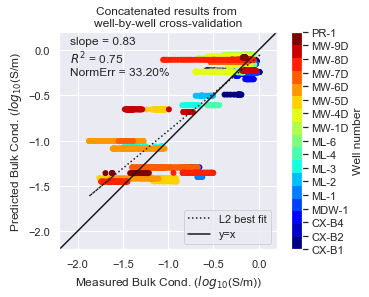

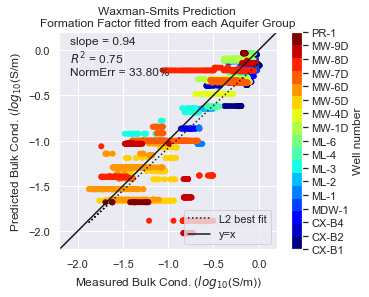

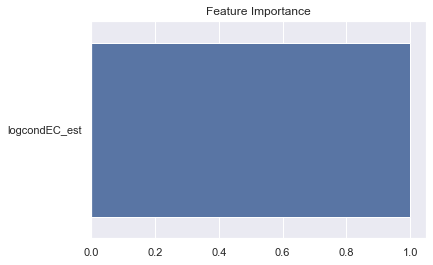

In [399]:
# #Plot 
# wellids = df2.Well.unique()

# for nam,y_test,y_predict in zip(wellids,y_tests,y_preds):
#     plt.scatter(y_test,y_predict,label=nam)
# plt.legend(loc=(1.05,.5))

c = np.concatenate( y_color, axis=0 )
# c = [welldict[nam] for nam in df_testing.Well]
cmap = cm.get_cmap('jet',len(np.unique(c)))

# bin_wiggle(y_predict,binsize=.1),
# y_pred = np.log10(1/np.power(10,(np.concatenate( y_preds, axis=0 ))))
# y_test = df_testing.logcild

# y_pred = np.log10(1/np.power(10,np.concatenate( y_preds, axis=0 )))
# y_test=  np.log10(1/np.power(10,df_testing.logcondEC1f.values))

y_pred = np.concatenate( y_preds, axis=0 )
y_test= df_testing.logcild

f,ax = plt.subplots(1,figsize=(5,4))
plt.xlim(-2.2,.2)
plt.ylim(-2.2,.2)
ax.set_aspect('equal')
f,ax = x_y_regression(y_test,
                      y_pred,
#                         bin_wiggle(np.concatenate( y_tests, axis=0 )),
#                       np.concatenate( y_preds, axis=0 ),                      
#                         bin_wiggle(np.concatenate( y_tests, axis=0 )),
#                       bin_wiggle(np.concatenate( y_preds, axis=0 ),binsize=.1),
                      c,
                      ax=ax,
                      plotslp=True,slpname='slope',plotone2one=True,
                      edgecolors='k',linewidth=0,cmap=cmap)
plt.xlabel('Measured Bulk Cond. ($log_{10}$(S/m))')
plt.ylabel('Predicted Bulk Cond. ($log_{10}$(S/m)')
plt.title('Concatenated results from \nwell-by-well cross-validation')
plt.legend(loc='lower right')
cb = plt.colorbar()
cb.ax.set_ylabel('Well number')
ticks=  [num for nam,num in welldict.items() if (nam in allwells)]
ticklabels = [nam for nam,num in welldict.items() if (nam in allwells)]
# ticklabels = [nam for num,nam in enumerate(aq_names)]

cb.set_ticks(ticks)
cb.set_ticklabels(ticklabels)
# sns.kdeplot(np.concatenate( y_tests, axis=0 ),bin_wiggle(np.concatenate( y_preds, axis=0 ),binsize=.1),n_levels=20,shade=False,shade_lowest=False)
# # plt.axis('off')
# plt.xlim([-1.25,2])
# plt.ylim([-1.25,2])
plt.savefig(figdir.joinpath('RF_pred_logcild_MPWSP.png'),dpi=300,bbox_inches='tight')
plt.show()


# y_test = np.log10(df_testing.RILD.values)
# y_pred = df_testing.logrild_pred_ws.values
y_test    = df_testing.logcild
y_pred = np.log10(1/np.power(10,df_testing.logrild_pred_ws))

c = np.asarray([welldict[nam] for nam in df_testing.Well])


msk=~np.isnan(y_pred)
y_test = y_test[msk]
y_pred = y_pred[msk]
c = c[msk]
cmap = cm.get_cmap('jet',len(np.unique(c)))
f,ax = plt.subplots(1,figsize=(5,4))
plt.xlim(-2.2,.2)
plt.ylim(-2.2,.2)
ax.set_aspect('equal')

f,ax= x_y_regression(y_test,
                    y_pred,
                    c,
                    plotone2one=True,
                     ax=ax,
                    slpname='slope',edgecolors='k',linewidth=0,cmap=cmap)#,vmin=25,vmax=100);
# sns.kdeplot(y_test,y_pred,n_levels=20,shade=False,shade_lowest=False)

plt.xlabel('Measured Bulk Cond. ($log_{10}$(S/m))')
plt.ylabel('Predicted Bulk Cond. ($log_{10}$(S/m)')
plt.title('Waxman-Smits Prediction \nFormation Factor fitted from each Aquifer Group')
plt.legend(loc='lower right')
cb = plt.colorbar()
cb.ax.set_ylabel('Well number')
ticks=  [num for nam,num in welldict.items() if (nam in allwells)]
ticklabels = [nam for nam,num in welldict.items() if (nam in allwells)]
# ticklabels = [nam for num,nam in enumerate(aq_names)]
cb.set_ticks(ticks)
cb.set_ticklabels(ticklabels)
plt.legend(loc='lower right')

plt.savefig(figdir.joinpath('WS_pred_logcild_MPWSP.png'),dpi=300,bbox_inches='tight')
plt.show()

plt.figure()
scores = 0
for i in range(len(estimator.estimators_)):
    scores += np.asarray(estimator.estimators_).flatten()[i].feature_importances_
scores /= n_repeat
sns.barplot(x=scores,y=X_test.columns)
plt.title('Feature Importance');
# plt.savefig(figdir.joinpath('FeatureImportance.png'),bbox_inches='tight',dpi=300)
# export_tree(figdir,estimator.estimators_[0],max_depth=5,predictors=predictors,prefix='Tree_')

3052

In [46]:
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,GradientBoostingClassifier,RandomForestRegressor,AdaBoostClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import BayesianRidge,RANSACRegressor
from sklearn.utils import resample
from numpy.linalg import norm
df = update_FBS(df,'TDS1',breaks=np.arange(0,40000,3000))
df2 = update_df2()

np.random.seed(1)

n_repeat = 100# Number of iterations for computing expectations
max_depth = None
n_estimators = n_repeat
pcaobj = PCA
dopca=False

n_components = 4
max_features=5
####Choose the input data set#########
#Predict from water quality samples and lith
predicted = 'logcondEC1f'
# predictors = ['logrild_pred_ws','logrhoEC_est'] <-- 27% RFregressor predicting logrild_spline, 3 comp, 2feat
# predictors = ['logcild_pred_ws','logcondEC_est','aq_groupnum','X','Y','C','M','G','S','DEPT'] #<-- 26% RFregressor predicting logcild_spline 3 comp, 2feat 
# predictors = ['logcild_pred_ws','logcondEC_est','X','Y','aq_groupnum','DEPT_bin']#<-- 24% RFregressor predicting logcild, 5 feat, no PCA
predictors = ['logcild_pred_ws','logcondEC_est','X','Y','aq_groupnum','DEPT_bin','FBS']#<-- 23% RFregressor predicting logcild, 5 feat, no PCA
predictors = ['logcild_pred_ws','logcild','X','Y','aq_groupnum','DEPT_bin']#<-- 23% RFregressor predicting logcild, 5 feat, no PCA

colorcolumn = 'aq_groupnum'

# class_list = [-16,-17,-18,-19]

# estimator=BaggingClassifier(DecisionTreeClassifier(
#     max_depth=max_depth),n_estimators=n_estimators,bootstrap_features=True)
# estimator = DecisionTreeRegressor(max_depth=max_depth,criterion='mae')
# estimator=GradientBoostingClassifier(n_estimators=n_estimators,max_depth=5,max_features=n_components)
# estimator=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth)
# estimator=BayesianRidge(n_iter=1000,tol=.0001)
# estimator = BaggingRegressor(DecisionTreeRegressor(max_depth=max_depth,criterion='mae'),n_estimators=n_estimators)
estimator=RandomForestRegressor(n_estimators=n_estimators,max_depth=max_depth,
                                min_samples_leaf=1,oob_score=False,max_features=max_features,criterion='mse',bootstrap=True)
# estimator=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,min_samples_leaf=1,max_features=max_features,class_weight='balanced')
# estimator = BayesianRidge()
# estimator = RANSACRegressor()
y_preds = []
y_tests = []
y_color = []
errs = []
estimators = []
# df_testing= resample(df2,n_samples=10000)
df_testing = df2
# df_testing = df2.assign(samp=False)

df_testing = df_testing.assign(DEPT_bin = (np.round(df_testing.DEPT/100,0)*100).astype(np.int))
# df_testing = df_testing.assign(logrhoEC_est = np.log10(df_testing.loc[:,'Rw_est']))
df_testing = df_testing.assign(Region_bin = df_testing.loc[:,'Region']=='Marina')
df_testing = df_testing.assign(logrhoEC1f = np.log10(cond2rho(df_testing.loc[:,'EC1f'])))
df_testing = df_testing.assign(logcondEC1f = np.log10(df_testing.loc[:,'EC1f']))

df_testing = df_testing.assign(logrild = np.log10(df_testing.RILD))
df_testing = df_testing.assign(logrild_bin = (np.round(np.log10(df_testing.RILD),1)*10).values.astype(int))
df_testing = df_testing.assign(logcild_bin = np.round(np.log10(1/df_testing.RILD)*10,0))
df_testing = df_testing.assign(logcild_spline_bin = np.round(df_testing.logcild_spline*10,0))
df_testing = df_testing.assign(logcild = np.log10(1/df_testing.RILD))
df_testing = df_testing.assign(logcild_pred_ws = np.log10(1/np.power(10,df_testing.logrild_pred_ws)))
df_testing = df_testing.assign(err_ws = np.abs(np.log10(1/df_testing.RILD) - df_testing.logcild_pred_ws))

df_testing = df_testing.assign(cild_bin = np.round(1/df2.RILD*10,0))
df_testing = df_testing.assign(cond_est = 1/tds2rho_est(df2.TDS1))
df_testing = df_testing.assign(cond_est_bin = np.round( (df_testing.cond_est /1).astype(np.float),0)*1)
df_testing = df_testing.assign(logcond_est = np.log10((df_testing.cond_est).astype(np.float) ))
df_testing = df_testing.assign(logrhoEC_est = np.log10(tds2rho_est(df_testing.TDS1).astype(np.float)))
df_testing = df_testing.assign(logcondEC_est = np.log10(1/(tds2rho_est(df_testing.TDS1).astype(np.float))))

df_testing = df_testing.assign(logrild_conv_bin = (np.round(df_testing.logrild_conv,1)*10).values.astype(int))
df_testing = df_testing.assign(logfres = np.log10(df_testing.FRES))

list_of_conditions = (df2.RILD.notnull(),
                      df2.FBS.notnull(),
                      df2.lith.notnull(),
                      df2.Y.notnull(),
                      df2.Region=='Marina')

conditions = [df_testing.loc[:,predictor].notnull() for predictor in predictors]
df_testing = df_testing.loc[nested_logicals(df_testing,list_of_conditions,func=np.logical_and)]
# df_testing = df_testing.loc[df_testing.lithnum_bin_conv==1,:]


print(len(df_testing),len(df2.Region=='Marina'),len(df2.loc[np.logical_and(df2.Region=='Marina',df2.FBS.notnull())]))

3052 15813 3052


/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in log10
